# Analyser les facteurs de croissance et de distribution spatiale des propriétés Airbnb à New York


Les propriétés Airbnb à travers les villes sont une excellente alternative pour les voyageurs qui souhaitent trouver un logement relativement moins cher. Il offre également aux propriétaires la possibilité d'utiliser des pièces de rechange ou inutilisées comme source de revenu supplémentaire. Cependant, ces derniers temps, la propagation alarmante des propriétés Airbnb est devenue un sujet de débat parmi le public et les autorités de la ville à travers le monde.

Compte tenu de ce qui précède, une étude est réalisée dans cet exemple de cahier pour comprendre les facteurs qui alimentent la croissance généralisée du nombre d'inscriptions Airbnb. Celles-ci peuvent inclure les caractéristiques de localisation des quartiers concernés (qui dans ce cas, les secteurs de recensement de New York) ainsi que des informations qualitatives sur les habitants qui y résident. L'objectif est d'aider les urbanistes à faire face aux externalités négatives du phénomène Airbnb (et des locations similaires à court terme) en prenant une décision éclairée sur l'élaboration de politiques appropriées.

Les données primaires sont téléchargées sur le site Web Airbnb de la ville de New York. Les autres données comprennent les données du recensement de 2019 et 2017 utilisant les services d'enrichissement d'Esri et divers autres ensembles de données du portail NYCOpenData.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt


from datetime import datetime
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from IPython.core.pylabtools import figsize
import seaborn as sns


# Machine Learning models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
from sklearn import preprocessing

# Arcgis api imports
import arcgis
from arcgis.geoenrichment import Country
from arcgis.features import summarize_data
from arcgis.features.enrich_data import enrich_layer
from arcgis.features import SpatialDataFrame
from arcgis.features import use_proximity 
from arcgis.gis import GIS
from arcgis.features import summarize_data

In [2]:
gis = GIS(url='https://arcgis.com/', username='arcgis_python', password='P@ssword123')

## Accéder au jeu de données NYC Airbnb and Tracts

Données Airbnb - Elles contiennent des informations sur 48 000 propriétés Airbnb disponibles à New York en 2019. Il s'agit notamment de l'emplacement de la propriété, de ses caractéristiques de quartier et des installations de transport disponibles, des informations sur le propriétaire, les détails de la pièce, y compris le nombre de chambres, etc., et prix de location par nuit.

NYC Tracts - Il s'agit d'un fichier de formes polygonales composé de 2167 zones de New York, y compris la zone des zones ainsi que l'identifiant unique de chaque zone.

<Item title:"NYCTractData" type:Feature Layer Collection owner:api_data_owner>
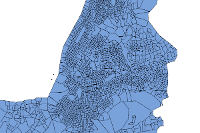

In [3]:
# Accessing NYCTracts
nyc_tract_full = gis.content.search('NYCTractData owner:api_data_owner', 'feature layer')[0]
nyc_tract_full

In [4]:
nyc_tracts_layer = nyc_tract_full.layers[0]

<Item title:"AnBNYC2019" type:Feature Layer Collection owner:api_data_owner>
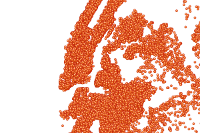

In [5]:
# Accessing airbnb NYC
airbnb_nyc2019 = gis.content.search('AnBNYC2019 owner:api_data_owner', 'feature layer')[0]
airbnb_nyc2019

In [6]:
airbnb_layer = airbnb_nyc2019.layers[0]

## Visualisation du jeu de données

In [7]:
# NYC Tracts
m1 = gis.map('New York City')
m1.add_layer(nyc_tracts_layer)
m1

MapView(layout=Layout(height='400px', width='100%'))

In [8]:
# NYC Airbnb Properties
m = gis.map('Springfield Gardens, NY')
m.add_layer(airbnb_layer)
m

MapView(layout=Layout(height='400px', width='100%'))

In [13]:
# extracting the dataframe from the layer and visualize it as a pandas dataframe
pd.set_option('display.max_columns', 110)
sdf_airbnb_layer = pd.DataFrame.spatial.from_layer(airbnb_layer)
sdf_airbnb_layer.head(2)

,FID,SHAPE,access,accommodat,airbnb,amenities,availabi_1,availabi_2,availabi_3,availabili,bathrooms,bed_type,bedrooms,beds,calculat_1,calculat_2,calculat_3,calculated,calendar_l,calendar_u,cancellati,city,cleaning_f,country,country_co,descriptio,experience,extra_peop,first_revi,guests_inc,has_availa,host_accep,host_has_p,host_ident,host_is_su,host_listi,host_locat,host_neigh,host_res_1,host_respo,host_since,host_total,house_rule,id,instant_bo,interactio,is_busines,is_locatio,jurisdicti,last_revie,last_scrap,latitude,license,longitude,market,maximum__1,maximum_ma,maximum_mi,maximum_ni,minimum__1,minimum_ma,minimum_mi,minimum_ni,monthly_pr,name,neighborho,neighbou_1,neighbou_2,neighbourh,notes,number_of1,number_of_,price,property_t,require__1,require_gu,requires_l,review_s_1,review_s_2,review_s_3,review_s_4,review_s_5,review_s_6,review_sco,reviews_pe,room_type,scrape_id,security_d,smart_loca,space,square_fee,state,street,summary,transit,weekly_pri,zipcode
0,1,"{'x': -8235507.210868829, 'y': 4964733.1453062...",,4,1,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",0,0,0,0,2.0,Real Bed,2,2,1,1,0,2,2019-06-03,4 weeks ago,moderate,Brooklyn,$60.00,United States,US,"Imagine a quiet, spacious apartment, with beau...",none,$0.00,2011-05-29,2,t,N/A,t,t,t,2,"New York, New York, United States",Park Slope,100%,within a day,2011-05-22,2,"No pets, no smoking. The $25/night for each gu...",121861,f,,f,t,,2016-05-02,2019-06-03,40.67644,,-73.98082,New York,730.0,730,2,730,2.0,730,2,2,,"Park Slope Apt:, Spacious 2 bedroom",,Park Slope,Brooklyn,Brooklyn,,0,23,165,Apartment,f,f,f,10,10,10,10,10,10,99,0.24,Entire home/apt,20200000000000,$250.00,"Brooklyn, NY","Imagine a quiet, spacious apartment, with beau...",1500,NY,"Brooklyn, NY, United States",,,"$1,050.00",11215
1,2,"{'x': -8231847.026011546, 'y': 4983593.6741002...",Everything in the studio is for their use.,3,1,"{TV,""Cable TV"",Wifi,""Air conditioning"",""Paid p...",28,43,296,8,1.0,Real Bed,0,2,1,1,0,2,2019-06-03,7 months ago,strict_14_with_grace_period,New York,$60.00,United States,US,"Comfortable, spacious studio in one of the mos...",none,$25.00,2011-05-30,1,t,N/A,t,f,f,2,"New York, New York, United States",Harlem,100%,within an hour,2011-05-23,2,no loud music no pets no children $300 dollar...,123784,t,As much as the guest would like.,f,t,,2019-05-17,2019-06-03,40.80481,,-73.94794,New York,365.0,365,2,365,2.0,365,2,2,"$3,200.00",NYC Studio for Rent in Townhouse,"The new restaurants, stores and cafes. Everyth...",Harlem,Manhattan,Harlem,45.00 dollar fee for air-conditioner in the su...,42,138,110,Apartment,t,t,f,10,9,10,10,10,9,94,1.41,Entire home/apt,20200000000000,$500.00,"New York, NY",This is a large studio room with a private bat...,0,NY,"New York, NY, United States","Comfortable, spacious studio in one of the mos...",,$735.00,10027


##  Nombre total de propriétés Airbnb par Tracts à New York

Le nombre de propriétés Airbnb par étendue doit être estimé à l'aide de la couche polygonale et de la couche ponctuelle Airbnb.

L'outil Agréger des points utilise des entités surfaciques pour résumer un ensemble d'entités ponctuelles. Les limites de l'entité de zone sont utilisées pour collecter les points dans chaque zone et les utiliser pour calculer des statistiques. La couche résultante affiche le nombre de points dans chaque zone. Ici, la couche polygonale est utilisée comme entité surfacique et la couche ponctuelle Airbnb est utilisée comme entité ponctuelle.

In [14]:
agg_result = summarize_data.aggregate_points(point_layer=airbnb_layer,
                                             polygon_layer=nyc_tracts_layer,
                                             output_name='airbnb_counts'+ str(datetime.now().microsecond))

In [15]:
agg_result

<Item title:"airbnb_counts190668" type:Feature Layer Collection owner:arcgis_python>

In [16]:
# mapping the aggregated airbnb data with darker areas showing more airbnb properties per tract
aggr_map = gis.map('NY', zoomlevel=10)
aggr_map.add_layer(agg_result,{"renderer":"ClassedColorRenderer", "field_name": "Point_Count"})
aggr_map

MapView(layout=Layout(height='400px', width='100%'), zoom=10.0)

In [17]:
airbnb_count_by_tract = agg_result.layers[0]

In [18]:
sdf_airbnb_count_by_tract = airbnb_count_by_tract.query().sdf

In [19]:
sdf_airbnb_count_by_tract = sdf_airbnb_count_by_tract.sort_values('geoid')
sdf_airbnb_count_by_tract.head()

,AnalysisArea,OBJECTID,Point_Count,SHAPE,Shape__Area,Shape__Length,aland,awater,countyfp,funcstat,geoid,intptlat,intptlon,mtfcc,name,namelsad,statefp,tractce
2095,1.044430,2096,0,"{'rings': [[[-8226256.9418, 4982172.581], [-82...",4.724201e+06,9395.023908,1579361,1125765,005,S,36005000100,+40.7934921,-073.8835318,G5020,1,Census Tract 1,36,000100
2059,0.533681,2060,0,"{'rings': [[[-8222638.612, 4985024.3226], [-82...",2.414911e+06,8067.034661,455322,926899,005,S,36005000200,+40.8045733,-073.8568585,G5020,2,Census Tract 2,36,000200
2067,0.585075,2068,15,"{'rings': [[[-8222012.885, 4985135.2266], [-82...",2.647647e+06,8312.955974,912392,602945,005,S,36005000400,+40.8089152,-073.8504884,G5020,4,Census Tract 4,36,000400
1668,0.187289,1669,1,"{'rings': [[[-8222181.7567, 4986069.1354], [-8...",8.478126e+05,3898.163149,485079,0,005,S,36005001600,+40.8188478,-073.8580764,G5020,16,Census Tract 16,36,001600
2127,1.074650,2128,24,"{'rings': [[[-8230028.8927, 4984061.5402], [-8...",4.862123e+06,11742.631147,1643654,1139660,005,S,36005001900,+40.8009990,-073.9093729,G5020,19,Census Tract 19,36,001900


## Enrichissement de tracts avec des données démographiques grâce au service de géo-enrichissement d'Esri

Les données d'entités sont maintenant créées à l'aide des informations démographiques sélectionnées pour chaque secteur. Ceci est accompli en accédant aux services de géo-enrichissement d'Esri, qui comprend les dernières données de recensement. L'ensemble du référentiel de données est d'abord visualisé, à partir duquel les variables pertinentes sont finalisées à partir d'une étude de la littérature. Ces variables sélectionnées sont recherchées pour être ajoutées dans l'ensemble de fonctionnalités.

In [20]:
# Displaying the various data topic available for geoenrichment for USA in the Esri database
usa = Country.get('US')
type(usa)
usa_data = usa.data_collections
df_usa_data = pd.DataFrame(usa_data)
df_usa_data.head()

,analysisVariable,alias,fieldCategory,vintage
dataCollectionID,,,,
1yearincrements,1yearincrements.AGE0_CY,2019 Population Age <1,2019 Age: 1 Year Increments (Esri),2019
1yearincrements,1yearincrements.AGE1_CY,2019 Population Age 1,2019 Age: 1 Year Increments (Esri),2019
1yearincrements,1yearincrements.AGE2_CY,2019 Population Age 2,2019 Age: 1 Year Increments (Esri),2019
1yearincrements,1yearincrements.AGE3_CY,2019 Population Age 3,2019 Age: 1 Year Increments (Esri),2019
1yearincrements,1yearincrements.AGE4_CY,2019 Population Age 4,2019 Age: 1 Year Increments (Esri),2019


In [21]:
# Filtering the unique topic under dataCollectionID
df_usa_data.reset_index(inplace=True)
list(df_usa_data.dataCollectionID.unique())

['1yearincrements',
 '5yearincrements',
 'ACS_Housing_Summary_rep',
 'ACS_Population_Summary_rep',
 'Age',
 'AgeDependency',
 'Age_50_Profile_rep',
 'Age_by_Sex_Profile_rep',
 'Age_by_Sex_by_Race_Profile_rep',
 'AtRisk',
 'AutomobilesAutomotiveProducts',
 'Automotive_Aftermarket_Expenditures_rep',
 'BabyProductsToysGames',
 'Business_Summary_rep',
 'CivicActivitiesPoliticalAffiliation',
 'ClothingShoesAccessories',
 'Community_Profile_rep',
 'DaytimePopulation',
 'Demographic_and_Income_Comparison_Profile_rep',
 'Demographic_and_Income_Profile_rep',
 'Disposable_Income_Profile_rep',
 'ElectronicsInternet',
 'Electronics_and_Internet_Market_Potential_rep',
 'Executive_Summary_rep',
 'Finances_Market_Potential_rep',
 'FinancialInsurance',
 'Financial_Expenditures_rep',
 'Generations',
 'Graphic_Profile_rep',
 'GroceryAlcoholicBeverages',
 'Health',
 'HealthPersonalCare',
 'HealthPersonalCareCEX',
 'Health_and_Beauty_Market_Potential_rep',
 'HistoricalHouseholds',
 'HistoricalHousing',
 '

In [22]:
df_usa_data[df_usa_data['alias'].str.contains('Nonprofit')]                        

,dataCollectionID,analysisVariable,alias,fieldCategory,vintage
10635,classofworker,classofworker.ACSMPRIVNP,2014-2018 ACS Civ Emp Male 16+:Priv Nonprofit,2014-2018 Class of Worker (ACS),2014-2018
10636,classofworker,classofworker.MOEMPRIVNP,2014-2018 MOE Civ Emp Male 16+:Priv Nonprofit,2014-2018 Class of Worker (ACS),2014-2018
10643,classofworker,classofworker.RELMPRIVNP,2014-2018 REL Civ Emp Male 16+:Priv Nonprofit,2014-2018 Class of Worker (ACS),2014-2018
10668,classofworker,classofworker.ACSFPRIVNP,2014-2018 ACS Civ Emp Female 16+:Priv Nonprofit,2014-2018 Class of Worker (ACS),2014-2018
10669,classofworker,classofworker.MOEFPRIVNP,2014-2018 MOE Civ Emp Female 16+:Priv Nonprofit,2014-2018 Class of Worker (ACS),2014-2018
10670,classofworker,classofworker.RELFPRIVNP,2014-2018 REL Civ Emp Female 16+:Priv Nonprofit,2014-2018 Class of Worker (ACS),2014-2018


In [23]:
enrichment_variables = {'classofworker.ACSCIVEMP':      'Employed Population Age 16+',
 'classofworker.ACSMCIVEMP':                      'Employed Male Pop Age 16+',
 'classofworker.ACSMPRIVNP':                      'Male 16+Priv Nonprofit',
 'classofworker.ACSMEPRIVP':                      'Male 16+:Priv Profit Empl',
 'classofworker.ACSMSELFI':                       'Male 16+:Priv Profit Self Empl',
 'classofworker.ACSMSTGOV':                       'Male 16+:State Govt Wrkr',
 'classofworker.ACSMFEDGOV':                      'Male 16+:Fed Govt Wrkr',
 'classofworker.ACSMSELFNI':                      'Male 16+:Self-Emp Not Inc',
 'classofworker.ACSMUNPDFM':                      'Male 16+:Unpaid Family Wrkr',              
 'classofworker.ACSFCIVEMP':                      'Female Pop Age 16+',
 'classofworker.ACSFEPRIVP':                      'Female 16+:Priv Profit Empl',
 'classofworker.ACSFSELFI':                       'Female 16+:Priv Profit Self Empl',                      
 'classofworker.ACSFPRIVNP':                      'Female 16+:Priv Nonprofit',
 'classofworker.ACSFLOCGOV':                      'Female 16+:Local Govt Wrkr',
 'classofworker.ACSFSTGOV':                       'Female 16+:State Govt Wrkr',
 'classofworker.ACSFFEDGOV':                      'Female 16+:Fed Govt Wrkr',                      
 'classofworker.ACSFSELFNI':                      'Female 16+:Self-Emp Not Inc',                      
 'classofworker.ACSFUNPDFM':                      'Female 16+:Unpaid Family Wrkr',                      
 'gender.MEDAGE_CY':                              '2019 Median Age',
 'Generations.GENALPHACY':                        '2019 Generation Alpha Population',
 'Generations.GENZ_CY':                           '2019 Generation Z Population',
 'Generations.MILLENN_CY':                        '2019 Millennial Population',
 'Generations.GENX_CY':                           '2019 Generation X Population',
 'Generations.BABYBOOMCY':                        '2019 Baby Boomer Population',
 'Generations.OLDRGENSCY':                        '2019 Silent & Greatest Generations Population',
 'Generations.GENBASE_CY':                        '2019 Population by Generation Base',
 'populationtotals.POPDENS_CY':                   '2019 Population Density',
 'DaytimePopulation.DPOP_CY':                     '2019 Total Daytime Population',
 'raceandhispanicorigin.WHITE_CY':                '2019 White Population',
 'raceandhispanicorigin.BLACK_CY':                '2019 Black Population',
 'raceandhispanicorigin.AMERIND_CY':              '2019 American Indian Population',
 'raceandhispanicorigin.ASIAN_CY':                '2019 Asian Population',
 'raceandhispanicorigin.PACIFIC_CY':              '2019 Pacific Islander Population',
 'raceandhispanicorigin.OTHRACE_CY':              '2019 Other Race Population',
 'raceandhispanicorigin.DIVINDX_CY':              '2019 Diversity Index',
 'households.ACSHHBPOV':                          'HHs: Inc Below Poverty Level',
 'households.ACSHHAPOV':                          'HHs:Inc at/Above Poverty Level',
 'households.ACSFAMHH':                           'ACS Family Households',
 'businesses.S01_BUS':                            'Total Businesses (SIC)',
 'businesses.N05_BUS':                            'Construction Businesses (NAICS)',
 'businesses.N08_BUS':                            'Retail Trade Businesses (NAICS)',
 'businesses.N21_BUS':                            'Transportation/Warehouse Bus (NAICS)',
 'ElectronicsInternet.MP09147a_B':                'Own any tablet',
 'ElectronicsInternet.MP09148a_B':                'Own any e-reader',
 'ElectronicsInternet.MP19001a_B':                'Have access to Internet at home',                
 'ElectronicsInternet.MP19070a_I':                'Index: Spend 0.5-0.9 hrs online(excl email/IM .',               
 'ElectronicsInternet.MP19071a_B':                'Spend <0.5 hrs online (excl email/IM time) daily',
 'populationtotals.TOTPOP_CY':                    '2019 Total Population',              
 'gender.MALES_CY':                               '2019 Male Population',
 'gender.FEMALES_CY':                             '2019 Female Population',
 'industry.EMP_CY':                               '2019 Employed Civilian Pop 16+',
 'industry.UNEMP_CY':                             '2019 Unemployed Population 16+',                     
 'industry.UNEMPRT_CY':                           '2019 Unemployment Rate',
 'commute.ACSWORKERS':                            'ACS Workers Age 16+',
 'commute.ACSDRALONE':                            'ACS Workers 16+: Drove Alone',
 'commute.ACSCARPOOL':                            'ACS Workers 16+: Carpooled',
 'commute.ACSPUBTRAN':                            'ACS Workers 16+: Public Transportation',
 'commute.ACSBUS':                                'ACS Workers 16+: Bus',
 'commute.ACSSTRTCAR':                            'ACS Workers 16+: Streetcar',
 'commute.ACSSUBWAY':                             'ACS Workers 16+: Subway',
 'commute.ACSRAILRD':                             'ACS Workers 16+: Railroad',
 'commute.ACSFERRY':                              'ACS Workers 16+: Ferryboat',
 'commute.ACSTAXICAB':                            'ACS Workers 16+: Taxicab',           
 'commute.ACSMCYCLE':                             'ACS Workers 16+: Motorcycle',
 'commute.ACSBICYCLE':                            'ACS Workers 16+: Bicycle',                             
 'commute.ACSWALKED':                             'ACS Workers 16+: Walked',
 'commute.ACSOTHTRAN':                            'ACS Workers 16+: Other Means',
 'commute.ACSWRKHOME':                            'ACS Wrkrs 16+: Worked at Home',
 'OwnerRenter.OWNER_CY':                          '2019 Owner Occupied HUs', 
 'OwnerRenter.RENTER_CY':                         '2019 Renter Occupied HUs', 
 'vacant.VACANT_CY':                              '2019 Vacant Housing Units', 
 'homevalue.MEDVAL_CY':                           '2019 Median Home Value',
 'housingunittotals.TOTHU_CY':                    '2019 Total Housing Units',
 'yearbuilt.ACSMEDYBLT':                          'ACS Median Year Structure Built: HUs',
 'SpendingTotal.X1001_X':                         '2019 Annual Budget Exp',
 'transportation.X6001_X':                        '2019 Transportation',
 'households.ACSTOTHH':                           'ACS Total Households',
 'DaytimePopulation.DPOPWRK_CY':                  '2019 Daytime Pop: Workers',
 'DaytimePopulation.DPOPRES_CY':                  '2019 Daytime Pop: Residents',
 'DaytimePopulation.DPOPDENSCY':                  '2019 Daytime Pop Density',
 'occupation.OCCPROT_CY':                         '2019 Occupation: Protective Service',
 'occupation.OCCFOOD_CY':                         '2019 Occupation: Food Preperation',
 'occupation.OCCPERS_CY':                         '2019 Occupation: Personal Care',
 'occupation.OCCADMN_CY':                         '2019 Occupation: Office/Admin',
 'occupation.OCCCONS_CY':                         '2019 Occupation: Construction/Extraction',
 'occupation.OCCPROD_CY':                         '2019 Occupation: Production'
                  }

In [24]:
# Enrichment operation using ArcGIS API for Python 
enrichment_variables_df = pd.DataFrame.from_dict(enrichment_variables, orient='index',columns=['Variable Definition'])
enrichment_variables_df.reset_index(level=0, inplace=True)
enrichment_variables_df.columns = ['AnalysisVariable','Variable Definition']
enrichment_variables_df.head()


,AnalysisVariable,Variable Definition
0,classofworker.ACSCIVEMP,Employed Population Age 16+
1,classofworker.ACSMCIVEMP,Employed Male Pop Age 16+
2,classofworker.ACSMPRIVNP,Male 16+Priv Nonprofit
3,classofworker.ACSMEPRIVP,Male 16+:Priv Profit Empl
4,classofworker.ACSMSELFI,Male 16+:Priv Profit Self Empl


In [25]:
# Convertng the variables names to list for passing them to the enrichment tool
variable_names = enrichment_variables_df['AnalysisVariable'].tolist()

# checking the firt few values of the list
variable_names[1:5]

['classofworker.ACSMCIVEMP',
 'classofworker.ACSMPRIVNP',
 'classofworker.ACSMEPRIVP',
 'classofworker.ACSMSELFI']

In [26]:
# Data Enriching operation
airbnb_count_by_tract_enriched = enrich_layer(airbnb_count_by_tract,
                                              analysis_variables = variable_names,
                                              output_name='airbnb_tract_enrich1'+ str(datetime.now().microsecond))

{"messageCode": "AO_100047", "message": "Enrichment may not be available for some features."}
{"messageCode": "AO_100000", "message": "Unable to detect country for study area at [15]."}
{"messageCode": "AO_100000", "message": "Unable to detect country for study area at [13]."}


In [27]:
# Extracting the resulting enriched dataframe after the geoenrichment method
sdf_airbnb_count_by_tract_enriched = airbnb_count_by_tract_enriched.layers[0].query().sdf

In [28]:
# Visualizing the data as a pandas dataframe
print(sdf_airbnb_count_by_tract_enriched.columns)
sdf_airbnb_count_by_tract_enriched_sorted = sdf_airbnb_count_by_tract_enriched.sort_values('geoid')
sdf_airbnb_count_by_tract_enriched_sorted.head()

Index(['ACSBICYCLE', 'ACSBUS', 'ACSCARPOOL', 'ACSCIVEMP', 'ACSDRALONE',
       'ACSFCIVEMP', 'ACSFEPRIVP', 'ACSFERRY', 'ACSFFEDGOV', 'ACSFLOCGOV',
       ...
       'geoid', 'intptlat', 'intptlon', 'mtfcc', 'name', 'namelsad',
       'populationToPolygonSizeRating', 'sourceCountry', 'statefp', 'tractce'],
      dtype='object', length=109)


,ACSBICYCLE,ACSBUS,ACSCARPOOL,ACSCIVEMP,ACSDRALONE,ACSFCIVEMP,ACSFEPRIVP,ACSFERRY,ACSFFEDGOV,ACSFLOCGOV,ACSFPRIVNP,ACSFSELFI,ACSFSELFNI,ACSFSTGOV,ACSFUNPDFM,ACSHHAPOV,ACSHHBPOV,ACSMCIVEMP,ACSMCYCLE,ACSMEDYBLT,ACSMEPRIVP,ACSMFEDGOV,ACSMPRIVNP,ACSMSELFI,ACSMSELFNI,ACSMSTGOV,ACSMUNPDFM,ACSOTHTRAN,ACSPUBTRAN,ACSRAILRD,ACSSTRTCAR,ACSSUBWAY,ACSTAXICAB,ACSWALKED,ACSWORKERS,ACSWRKHOME,AMERIND_CY,ASIAN_CY,AnalysisArea,BABYBOOMCY,BLACK_CY,DIVINDX_CY,DPOPDENSCY,DPOPRES_CY,DPOPWRK_CY,DPOP_CY,EMP_CY,ENRICH_FID,FEMALES_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,HasData,ID,MALES_CY,MEDAGE_CY,MEDVAL_CY,MILLENN_CY,MP09147a_B,MP09148a_B,MP19001a_B,MP19070a_I,MP19071a_B,N05_BUS,N08_BUS,N21_BUS,OBJECTID,OCCADMN_CY,OCCCONS_CY,OCCFOOD_CY,OCCPERS_CY,OCCPROD_CY,OCCPROT_CY,OLDRGENSCY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,POPDENS_CY,Point_Count,RENTER_CY,S01_BUS,SHAPE,Shape__Area,Shape__Length,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WHITE_CY,X1001_X,X6001_X,aggregationMethod,aland,apportionmentConfidence,awater,countyfp,funcstat,geoid,intptlat,intptlon,mtfcc,name,namelsad,populationToPolygonSizeRating,sourceCountry,statefp,tractce
2095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,194.0,1.044430,396.0,6016.0,81.4,475.9,0.0,497.0,497.0,0.0,2096.0,862.0,0.0,10471.0,3162.0,1599.0,1.0,45,9609.0,31.5,0.0,5308.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2096,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2629.0,0.0,27.0,10025.9,0,0.0,10.0,"{'rings': [[[-8226256.9418, 4982172.581], [-82...",4.724201e+06,9395.023908,0.0,10471.0,0.0,0.0,0.0,1489.0,0.0,0.0,BlockApportionment:US.BlockGroups,1579361,2.576,1125765,005,S,36005000100,+40.7934921,-073.8835318,G5020,1,Census Tract 1,2.191,US,36,000100
2059,0.0,230.0,94.0,1578.0,819.0,570.0,364.0,0.0,12.0,87.0,39.0,26.0,12.0,30.0,0.0,1121.0,207.0,1008.0,0.0,1958.0,711.0,15.0,60.0,38.0,30.0,50.0,0.0,0.0,540.0,0.0,0.0,310.0,17.0,99.0,1578.0,9.0,54.0,163.0,0.533681,876.0,1286.0,89.9,5823.5,2888.0,220.0,3108.0,1795.0,2060.0,2479.0,177.0,4638.0,915.0,1188.0,1.0,9,2159.0,35.0,437798.0,1233.0,1637.0,192.0,3091.0,67.0,250.0,2.0,3.0,3.0,2060,257.0,79.0,76.0,32.0,79.0,21.0,249.0,1440.0,768.0,15.0,8690.3,0,667.0,36.0,"{'rings': [[[-8222638.612, 4985024.3226], [-82...",2.414911e+06,8067.034661,1511.0,4638.0,5.3,100.0,76.0,1404.0,106532171.0,11165486.0,BlockApportionment:US.BlockGroups,455322,2.576,926899,005,S,36005000200,+40.8045733,-073.8568585,G5020,2,Census Tract 2,2.191,US,36,000200
2067,11.0,372.0,215.0,2808.0,1235.0,1338.0,779.0,0.0,32.0,284.0,182.0,20.0,33.0,8.0,0.0,1756.0,207.0,1470.0,0.0,1999.0,842.0,61.0,120.0,50.0,96.0,8.0,0.0,52.0,1133.0,13.0,0.0,748.0,6.0,22.0,2730.0,56.0,52.0,155.0,0.585075,1168.0,1925.0,90.4,6855.2,3470.0,541.0,4011.0,2890.0,2068.0,3231.0,246.0,6288.0,1372.0,1613.0,1.0,17,3057.0,35.3,392481.0,1622.0,2233.0,349.0,4390.0,92.0,215.0,5.0,8.0,2.0,2068,432.0,70.0,113.0,99.0,45.0,276.0,267.0,2067.0,1384.0,5.0,10746.9,15,658.0,54.0,"{'rings': [[[-8222012.885, 4985135.2266], [-82...",2.647647e+06,8312.955974,2150.0,6288.0,5.0,153.0,108.0,1662.0,166787168.0,17539648.0,BlockApportionment:US.BlockGroups,912392,2.576,602945,005,S,36005000400,+40.8089152,-073.8504884,G5020,4,Census Tract 4,2.191,US,36,000400
1668,0.0,468.0,116.0,2313.0,785.0,1306.0,773.0,0.0,27.0,338.0,101.0,11.0,45.0,11.0,0.0,1539.0,443.0,1007.0,0.0,1972.0,624.0,14.0,40.0,112.0,0.0,42.0,0.0,10.0,1108.0,0.0,0.0,640.0,15.0,116.0,2302.0,152.0,54.0,78.0,0.187289,1205.0,2298.0,87.8,30304.3,3716.0,1960.0,5676.0,2332.0,1669.0,3365.0,238.0,5982.0,1100.0,1484.0,1.0,18,2617.0,35.6,415686.0,1515.0,1769.0,211.0,3424.0,70.0,247.0,2.0,4.0,2.0,1669,378.0,23.0,157.0,219.0,70.0,131.0,440.0,1550.0,356.0,0.0,31938.1,1,1675.0,53.0,"{'rings': [[[-8222181.7567, 4986069.1354], [-8...",8.478126e+05,3898.163149,2099.0,5982.0,5.2,128.0,68.0,1649.0,92988868.0,9541987.0,BlockApportionment:US.BlockGroups,485079,2.576,0,005,S,36005001600,+40.8188478,-073.8580764,G5020,16,Census Tract 16,2.191,US,36,00

In [29]:
enrichment_variables_df.head()

,AnalysisVariable,Variable Definition
0,classofworker.ACSCIVEMP,Employed Population Age 16+
1,classofworker.ACSMCIVEMP,Employed Male Pop Age 16+
2,classofworker.ACSMPRIVNP,Male 16+Priv Nonprofit
3,classofworker.ACSMEPRIVP,Male 16+:Priv Profit Empl
4,classofworker.ACSMSELFI,Male 16+:Priv Profit Self Empl


In [30]:
enrichment_variables_copy = enrichment_variables_df.copy()
enrichment_variables_copy.head(2)

,AnalysisVariable,Variable Definition
0,classofworker.ACSCIVEMP,Employed Population Age 16+
1,classofworker.ACSMCIVEMP,Employed Male Pop Age 16+


In [31]:
enrichment_variables_copy['AnalysisVariable'] = enrichment_variables_copy.AnalysisVariable.str.split(pat='.', expand=True)[1]
enrichment_variables_copy

,AnalysisVariable,Variable Definition
0,ACSCIVEMP,Employed Population Age 16+
1,ACSMCIVEMP,Employed Male Pop Age 16+
2,ACSMPRIVNP,Male 16+Priv Nonprofit
3,ACSMEPRIVP,Male 16+:Priv Profit Empl
4,ACSMSELFI,Male 16+:Priv Profit Self Empl
5,ACSMSTGOV,Male 16+:State Govt Wrkr
6,ACSMFEDGOV,Male 16+:Fed Govt Wrkr
7,ACSMSELFNI,Male 16+:Self-Emp Not Inc
8,ACSMUNPDFM,Male 16+:Unpaid Family Wrkr
9,ACSFCIVEMP,Female Pop Age 16+


In [32]:
enrichment_variables_copy.set_index("AnalysisVariable", drop=True, inplace=True)
dictionary = enrichment_variables_copy.to_dict()
new_columns = dictionary['Variable Definition']

In [33]:
# Field renamed and new dataframe visualized
pd.set_option('display.max_columns', 150)
sdf_airbnb_count_by_tract_enriched_sorted.rename(columns=new_columns, inplace=True)
sdf_airbnb_count_by_tract_enriched_sorted.head()

,ACS Workers 16+: Bicycle,ACS Workers 16+: Bus,ACS Workers 16+: Carpooled,Employed Population Age 16+,ACS Workers 16+: Drove Alone,Female Pop Age 16+,Female 16+:Priv Profit Empl,ACS Workers 16+: Ferryboat,Female 16+:Fed Govt Wrkr,Female 16+:Local Govt Wrkr,Female 16+:Priv Nonprofit,Female 16+:Priv Profit Self Empl,Female 16+:Self-Emp Not Inc,Female 16+:State Govt Wrkr,Female 16+:Unpaid Family Wrkr,HHs:Inc at/Above Poverty Level,HHs: Inc Below Poverty Level,Employed Male Pop Age 16+,ACS Workers 16+: Motorcycle,ACS Median Year Structure Built: HUs,Male 16+:Priv Profit Empl,Male 16+:Fed Govt Wrkr,Male 16+Priv Nonprofit,Male 16+:Priv Profit Self Empl,Male 16+:Self-Emp Not Inc,Male 16+:State Govt Wrkr,Male 16+:Unpaid Family Wrkr,ACS Workers 16+: Other Means,ACS Workers 16+: Public Transportation,ACS Workers 16+: Railroad,ACS Workers 16+: Streetcar,ACS Workers 16+: Subway,ACS Workers 16+: Taxicab,ACS Workers 16+: Walked,ACS Workers Age 16+,ACS Wrkrs 16+: Worked at Home,2019 American Indian Population,2019 Asian Population,AnalysisArea,2019 Baby Boomer Population,2019 Black Population,2019 Diversity Index,2019 Daytime Pop Density,2019 Daytime Pop: Residents,2019 Daytime Pop: Workers,2019 Total Daytime Population,2019 Employed Civilian Pop 16+,ENRICH_FID,2019 Female Population,2019 Generation Alpha Population,2019 Population by Generation Base,2019 Generation X Population,2019 Generation Z Population,HasData,ID,2019 Male Population,2019 Median Age,2019 Median Home Value,2019 Millennial Population,Own any tablet,Own any e-reader,Have access to Internet at home,Index: Spend 0.5-0.9 hrs online(excl email/IM .,Spend <0.5 hrs online (excl email/IM time) daily,Construction Businesses (NAICS),Retail Trade Businesses (NAICS),Transportation/Warehouse Bus (NAICS),OBJECTID,2019 Occupation: Office/Admin,2019 Occupation: Construction/Extraction,2019 Occupation: Food Preperation,2019 Occupation: Personal Care,2019 Occupation: Production,2019 Occupation: Protective Service,2019 Silent & Greatest Generations Population,2019 Other Race Population,2019 Owner Occupied HUs,2019 Pacific Islander Population,2019 Population Density,Point_Count,2019 Renter Occupied HUs,Total Businesses (SIC),SHAPE,Shape__Area,Shape__Length,2019 Total Housing Units,2019 Total Population,2019 Unemployment Rate,2019 Unemployed Population 16+,2019 Vacant Housing Units,2019 White Population,2019 Annual Budget Exp,2019 Transportation,aggregationMethod,aland,apportionmentConfidence,awater,countyfp,funcstat,geoid,intptlat,intptlon,mtfcc,name,namelsad,populationToPolygonSizeRating,sourceCountry,statefp,tractce
2095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,194.0,1.044430,396.0,6016.0,81.4,475.9,0.0,497.0,497.0,0.0,2096.0,862.0,0.0,10471.0,3162.0,1599.0,1.0,45,9609.0,31.5,0.0,5308.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2096,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2629.0,0.0,27.0,10025.9,0,0.0,10.0,"{'rings': [[[-8226256.9418, 4982172.581], [-82...",4.724201e+06,9395.023908,0.0,10471.0,0.0,0.0,0.0,1489.0,0.0,0.0,BlockApportionment:US.BlockGroups,1579361,2.576,1125765,005,S,36005000100,+40.7934921,-073.8835318,G5020,1,Census Tract 1,2.191,US,36,000100
2059,0.0,230.0,94.0,1578.0,819.0,570.0,364.0,0.0,12.0,87.0,39.0,26.0,12.0,30.0,0.0,1121.0,207.0,1008.0,0.0,1958.0,711.0,15.0,60.0,38.0,30.0,50.0,0.0,0.0,540.0,0.0,0.0,310.0,17.0,99.0,1578.0,9.0,54.0,163.0,0.533681,876.0,1286.0,89.9,5823.5,2888.0,220.0,3108.0,1795.0,2060.0,2479.0,177.0,4638.0,915.0,1188.0,1.0,9,2159.0,35.0,437798.0,1233.0,1637.0,192.0,3091.0,67.0,250.0,2.0,3.0,3.0,2060,257.0,79.0,76.0,32.0,79.0,21.0,249.0,1440.0,768.0,15.0,8690.3,0,667.0,36.0,"{'rings': [[[-8222638.612, 4985024.3226], [-82...",2.414911e+06,8067.034661,1511.0,4638.0,5.3,100.0,76.0,1404.0,106532171.0,11165486.0,BlockApportionment:US.BlockGroups,455322,2.576,926899,005,S,36005000200,+40.8045733,-073.8568585,G5020,2,Census Tract 2,2.191,US,36,000200
2067,11.0,372.0,215.0,

In [34]:
# accessing the various city feature shapefile from arcgis portal
busi_distr = gis.content.search('BusinessDistricts owner:api_data_owner', 'feature layer')[0]
cbd = gis.content.search('NYCBD owner:api_data_owner', 'feature layer')[0]
bus_stop = gis.content.search('NYCBusStop owner:api_data_owner', 'feature layer')[0]
hotels = gis.content.search('NYCHotels owner:api_data_owner', 'feature layer')[0]
railroad = gis.content.search('NYCRailroad owner:api_data_owner', 'feature layer')[0]
subwy_rt = gis.content.search('NYCSubwayRoutes owner:api_data_owner', 'feature layer')[0]
subwy_stn = gis.content.search('NYCSubwayStation owner:api_data_owner', 'feature layer')[0]

In [35]:
bus_stop_lyr = bus_stop.layers[0]
cbd_lyr = cbd.layers[0] 
hotels_lyr = hotels.layers[0] 
subwy_stn_lyr =subwy_stn.layers[0]
subwy_rt_lyr = subwy_rt.layers[0] 
railroad_lyr = railroad.layers[0]
busi_distrs_lyr = busi_distr.layers[0] 

In [36]:
# Avoid warning for chain operation
pd.set_option('mode.chained_assignment', None) 

# Estimating Tract to hotel distances
tract_hotel_dist = use_proximity.find_nearest(nyc_tracts_layer,
                                              hotels_lyr,
                                              measurement_type='StraightLine',
                                              max_count=1,
                                              output_name='ny_tract_hotel_dist1' + str(datetime.now().microsecond))

In [37]:
tract_hotel_dist.layers

[<FeatureLayer url:"https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/ny_tract_hotel_dist1245504/FeatureServer/0">,
 <FeatureLayer url:"https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/ny_tract_hotel_dist1245504/FeatureServer/1">]

In [38]:
tract_hotel_dist_lyr = tract_hotel_dist.layers[1]
sdf_tract_hotel_dist_lyr = pd.DataFrame.spatial.from_layer(tract_hotel_dist_lyr)
sdf_tract_hotel_dist_lyr.head()

,From_ID,From_Name,From_Shape__Area,From_Shape__Length,From_aland,From_awater,From_countyfp,From_funcstat,From_geoid,From_intptlat,From_intptlon,From_mtfcc,From_namelsad,From_statefp,From_tractce,NearRank,OBJECTID,SHAPE,To_ACRES,To_ADD_ADDR,To_ADD_CITY,To_ADD_OWNER,To_ADD_POBOX,To_ADD_STATE,To_ADD_ZIP,To_AGDISTCODE,To_AGDISTNAME,To_BLDG_DESC,To_BLDG_STYLE,To_BOOK,To_CALC_ACRES,To_COUNTY,To_CT_NAME,To_CT_SWIS,To_DEPTH,To_DUP_GEO,To_FRONT,To_FUEL_DESC,To_FUEL_TYPE,To_FULL_MV,To_GRID_EAST,To_GRID_NORTH,To_HEAT_DESC,To_HEAT_TYPE,To_ID,To_LAND_AV,To_LOC_STREET,To_LOC_ST_NBR,To_LOC_UNIT,To_LOC_ZIP,To_MAIL_ADDR,To_MAIL_CITY,To_MAIL_STATE,To_MAIL_ZIP,To_MUNI_NAME,To_MUNI_PCLID,To_NAMESOURCE,To_NBR_BEDRM,To_NBR_F_BATH,To_NBR_KITCHN,To_NYS_NAME,To_OWNER_TYPE,To_PAGE,To_PARCELADDR,To_PO_BOX,To_PRINT_KEY,To_PRMY_OWNER,To_PROP_CLASS,To_ROLL_SECT,To_ROLL_YR,To_SBL,To_SCH_CODE,To_SCH_NAME,To_SEWER_DESC,To_SEWER_TYPE,To_SPATIAL_YR,To_SQFT_LIV,To_SQ_FT,To_SWIS,To_SWISPKID,To_SWISSBLID,To_Shape__Area,To_Shape__Length,To_TOTAL_AV,To_USEDASCODE,To_USEDASDESC,To_UTILITIES,To_UTIL_DESC,To_WATER_DESC,To_WATER_SUPP,To_YR_BLT,Total_Miles
0,1332,227.03,72591.234375,1083.721395,41502,0,005,S,36005022703,+40.8440198,-073.9104999,G5020,Census Tract 227.03,36,022703,1,1,"{'paths': [[[-8227552.1448, 4989516.0602], [-8...",0,,,,,,,,,Miscellaneous,H9,0,0.162924,Bronx,Bronx,600100,159,,42,,,0,1011886,248352,,,30,202500,WEBSTER AVENUE,1930,,10457,,,,,Bronx,,,0,0,0,,8,0,1930 WEBSTER AVENUE,,,WEBSTER TREMONT EQUIT,05,,2017,2030270010,09,,,,2017,19110,6753,600100,,6001002030270010,1154.062500,166.305662,1531800,,,,,,,1931,0.519338
1,501,207.01,82598.628906,1212.182959,47273,0,061,S,36061020701,+40.8089775,-073.9584600,G5020,Census Tract 207.01,36,020701,1,2,None,0,,,,,,,,,Dormitories,H8,0,0.237481,New York,Manhattan,620100,100,,101,,,0,995721,234272,,,701,389700,AMSTERDAM AVENUE,1235,,10027,,,,,Manhattan,,,0,0,0,,8,0,1235 AMSTERDAM AVENUE,,,BARNARD COLLEGE,08,,2017,1019630030,03,,,,2017,79036,10092,620100,,6201001019630030,1680.277344,163.992960,6787350,,,,,,,1968,0.000000
2,469,174.02,88608.671875,1246.964673,50730,0,061,S,36061017402,+40.7968026,-073.9471624,G5020,Census Tract 174.02,36,017402,1,3,None,0,,,,,,,,,Dormitories,H8,0,0.338975,New York,Manhattan,620100,101,,142,,,0,998966,229316,,,695,1291050,EAST 110 STREET,55,,10029,,,,,Manhattan,,,0,0,0,,8,0,55 EAST 110 STREET,,,EDWIN GOULD RESIDENCE,08,,2017,1016160024,04,,,,2017,37570,14347,620100,,6201001016160024,2397.410156,198.095165,3051450,,,,,,,2004,0.000000
3,454,160.02,89790.902344,1256.907546,51422,0,061,S,36061016002,+40.7878787,-073.9536853,G5020,Census Tract 160.02,36,016002,1,4,None,0,,,,,,,,,Dormitories,H8,0,0.742213,New York,Manhattan,620100,101,,305,,,0,997421,226355,,,689,6925950,EAST 98 STREET,50,,10029,,,,,Manhattan,,,0,0,0,,8,0,50 EAST 98 STREET,,,MSMC RESIDENTIAL REAL,08,,2017,1016030039,02,,,,2017,240000,30781,620100,,6201001016030039,5248.046875,332.868992,8974350,,,,,,,1984,0.000000
4,440,150.01,90155.261719,1257.359120,51643,0,061,S,36061015001,+40.7801987,-073.9592834,G5020,Census Tract 150.01,36,015001,1,5,"{'paths': [[[-8232878.2271, 4979973.2013], [-8...",0,,,,,,,,,Transient Occupancy - Midtown Manhattan Area,H3,0,0.036426,New York,Manhattan,620100,101,,26,,,0,996841,223341,,,687,1395000,EAST 87 STREET,164,,10128,,,,,Manhattan,,,0,0,0,,8,0,164 EAST 87 STREET,,,164 EAST 87TH ST LLC,05,,2017,1015150045,02,,,,2017,18300,2571,620100,,6201001015150045,257.500000,94.764453,4627350,,,,,,,1930,0.139874


In [39]:
# Final hotel Distances in feet — Here in each row column "hotel_dist" returns the distance of the nearest hotel from that tract indicated by its geoids.
# For example in the first row the tract with ID 36005000100 has a nearest hotel at 5571.75 feet away from it. 
sdf_tract_hotel_dist_lyr_new = sdf_tract_hotel_dist_lyr[['From_geoid', 'Total_Miles']]
sdf_tract_hotel_dist_lyr_new['hotel_dist'] = round(sdf_tract_hotel_dist_lyr_new['Total_Miles'] * 5280, 2)
sdf_tract_hotel_dist_lyr_new.sort_values('From_geoid').head()

,From_geoid,Total_Miles,hotel_dist
2095,36005000100,1.055256,5571.75
2059,36005000200,1.039099,5486.44
2067,36005000400,0.472664,2495.67
1668,36005001600,0.585977,3093.96
2127,36005001900,0.000000,0.00


In [40]:
# Estimating Busstop distances from tracts
tract_bustop_dist = use_proximity.find_nearest(nyc_tracts_layer,
                                               bus_stop_lyr,
                                               measurement_type='StraightLine',
                                               max_count=1,
                                               output_name='ny_tract_bus_stop_dist'+ str(datetime.now().microsecond))
tract_bustop_dist_lyr = tract_bustop_dist.layers[1]
sdf_tract_bustop_dist_lyr = pd.DataFrame.spatial.from_layer(tract_bustop_dist_lyr)

In [41]:
# Final Bustop Distances in feet — Here in each row column "busstop_dist" returns the distance of the nearest bus stop 
# from that tract indicated by its geoids 
sdf_tract_bustop_dist_lyr_new = sdf_tract_bustop_dist_lyr[['From_geoid', 'Total_Miles']]
sdf_tract_bustop_dist_lyr_new['busstop_dist'] = round(sdf_tract_bustop_dist_lyr_new['Total_Miles'] * 5280)
sdf_tract_bustop_dist_lyr_new.sort_values('From_geoid').head()

,From_geoid,Total_Miles,busstop_dist
2095,36005000100,0.744344,3930.0
2059,36005000200,0.005983,32.0
2067,36005000400,0.000000,0.0
1668,36005001600,0.000000,0.0
2127,36005001900,0.000000,0.0


In [42]:
# estimating number of bus stops per tract
num_bustops_tracts = summarize_data.aggregate_points(point_layer=bus_stop_lyr,
                                                   polygon_layer=nyc_tracts_layer,
                                                   output_name='bustops_by_tracts'+ str(datetime.now().microsecond)) 

In [43]:
num_bustops_tracts_lyr = num_bustops_tracts.layers[0]
sdf_num_bustops_tracts_lyr = pd.DataFrame.spatial.from_layer(num_bustops_tracts_lyr)
sdf_num_bustops_tracts_lyr.head()

,AnalysisArea,OBJECTID,Point_Count,SHAPE,Shape__Area,Shape__Length,aland,awater,countyfp,funcstat,geoid,intptlat,intptlon,mtfcc,name,namelsad,statefp,tractce
0,0.016024,1,1,"{'rings': [[[-8227813.3004, 4989345.3624], [-8...",72591.234375,1083.721395,41502,0,005,S,36005022703,+40.8440198,-073.9104999,G5020,227.03,Census Tract 227.03,36,022703
1,0.018252,2,2,"{'rings': [[[-8233183.0202, 4984115.3687], [-8...",82598.628906,1212.182959,47273,0,061,S,36061020701,+40.8089775,-073.9584600,G5020,207.01,Census Tract 207.01,36,020701
2,0.019587,3,1,"{'rings': [[[-8231989.6748, 4982433.1457], [-8...",88608.671875,1246.964673,50730,0,061,S,36061017402,+40.7968026,-073.9471624,G5020,174.02,Census Tract 174.02,36,017402
3,0.019854,4,1,"{'rings': [[[-8232691.8783, 4981159.0609], [-8...",89790.902344,1256.907546,51422,0,061,S,36061016002,+40.7878787,-073.9536853,G5020,160.02,Census Tract 160.02,36,016002
4,0.019939,5,0,"{'rings': [[[-8233292.0018, 4980071.8459], [-8...",90155.261719,1257.359120,51643,0,061,S,36061015001,+40.7801987,-073.9592834,G5020,150.01,Census Tract 150.01,36,015001


In [44]:
# Number of Bus stops per tract — Here in each row column "num_bustop" returns the number of bus stops inside respective tracts 
sdf_num_bustops_tracts_lyr_new = sdf_num_bustops_tracts_lyr[['geoid', 'Point_Count']] 
sdf_num_bustops_tracts_lyr_new = sdf_num_bustops_tracts_lyr_new.rename(columns={'Point_Count':'num_bustop'})
sdf_num_bustops_tracts_lyr_new.sort_values('geoid').head()

,geoid,num_bustop
2095,36005000100,0
2059,36005000200,0
2067,36005000400,1
1668,36005001600,3
2127,36005001900,2


In [45]:
# estimating tracts distances from CBD 
tract_cbd_dist=use_proximity.find_nearest(nyc_tracts_layer,
                                          cbd_lyr,
                                          measurement_type='StraightLine',
                                          max_count=1,
                                          output_name='ny_tract_cbd_dist'+ str(datetime.now().microsecond))
tract_cbd_dist_lyr = tract_cbd_dist.layers[1]
sdf_tract_cbd_dist_lyr = pd.DataFrame.spatial.from_layer(tract_cbd_dist_lyr)
sdf_tract_cbd_dist_lyr.head()

,From_ID,From_Name,From_Shape__Area,From_Shape__Length,From_aland,From_awater,From_countyfp,From_funcstat,From_geoid,From_intptlat,From_intptlon,From_mtfcc,From_namelsad,From_statefp,From_tractce,NearRank,OBJECTID,SHAPE,To_ID,To_Shape__Area,To_Shape__Length,To_bid,To_borough,To_date_creat,To_date_modif,To_objectid,To_shape_area,To_shape_len,To_time_creat,To_time_modif,Total_Miles
0,1332,227.03,72591.234375,1083.721395,41502,0,005,S,36005022703,+40.8440198,-073.9104999,G5020,Census Tract 227.03,36,022703,1,1,"{'paths': [[[-8227840.685, 4989242.9453], [-82...",1,198651.394531,2349.824219,Bryant Park BID,Manhattan,2008-11-19,2016-10-31,58,None,None,00:00:00.000,00:00:00.000,7.102363
1,501,207.01,82598.628906,1212.182959,47273,0,061,S,36061020701,+40.8089775,-073.9584600,G5020,Census Tract 207.01,36,020701,1,2,"{'paths': [[[-8233012.3673, 4983978.5918], [-8...",1,198651.394531,2349.824219,Bryant Park BID,Manhattan,2008-11-19,2016-10-31,58,None,None,00:00:00.000,00:00:00.000,3.809966
2,469,174.02,88608.671875,1246.964673,50730,0,061,S,36061017402,+40.7968026,-073.9471624,G5020,Census Tract 174.02,36,017402,1,3,"{'paths': [[[-8231927.2364, 4982389.3819], [-8...",1,198651.394531,2349.824219,Bryant Park BID,Manhattan,2008-11-19,2016-10-31,58,None,None,00:00:00.000,00:00:00.000,3.363737
3,454,160.02,89790.902344,1256.907546,51422,0,061,S,36061016002,+40.7878787,-073.9536853,G5020,Census Tract 160.02,36,016002,1,4,"{'paths': [[[-8232719.7081, 4981110.3946], [-8...",1,198651.394531,2349.824219,Bryant Park BID,Manhattan,2008-11-19,2016-10-31,58,None,None,00:00:00.000,00:00:00.000,2.658677
4,440,150.01,90155.261719,1257.359120,51643,0,061,S,36061015001,+40.7801987,-073.9592834,G5020,Census Tract 150.01,36,015001,1,5,"{'paths': [[[-8233341.205, 4979982.316], [-823...",1,198651.394531,2349.824219,Bryant Park BID,Manhattan,2008-11-19,2016-10-31,58,None,None,00:00:00.000,00:00:00.000,2.055165


In [46]:
# Final CBD distances in feet — Here in each row the column "cbd_dst" returns the distance of the CBD from respective tracts
sdf_tract_cbd_dist_lyr_new = sdf_tract_cbd_dist_lyr[['From_geoid', 'Total_Miles']]
sdf_tract_cbd_dist_lyr_new['cbd_dist'] = round(sdf_tract_cbd_dist_lyr_new['Total_Miles'] * 5280, 2) 
sdf_tract_cbd_dist_lyr_new.sort_values('From_geoid').head()

,From_geoid,Total_Miles,cbd_dist
2095,36005000100,4.999247,26396.02
2059,36005000200,6.858514,36212.95
2067,36005000400,7.321927,38659.77
1668,36005001600,7.525535,39734.83
2127,36005001900,4.333590,22881.35


In [47]:
# Estimating NYCSubwayStation distances from tracts 
tract_subwy_stn_dist = use_proximity.find_nearest(nyc_tracts_layer,
                                                  subwy_stn_lyr,
                                                  measurement_type='StraightLine',
                                                  max_count=1,
                                                  output_name='ny_tract_subway_station_dist'+ str(datetime.now().microsecond))
tract_subwy_stn_dist_lyr = tract_subwy_stn_dist.layers[1]
sdf_tract_subwy_stn_dist_lyr = pd.DataFrame.spatial.from_layer(tract_subwy_stn_dist_lyr)
sdf_tract_subwy_stn_dist_lyr.head()

,From_ID,From_Name,From_Shape__Area,From_Shape__Length,From_aland,From_awater,From_countyfp,From_funcstat,From_geoid,From_intptlat,From_intptlon,From_mtfcc,From_namelsad,From_statefp,From_tractce,NearRank,OBJECTID,SHAPE,To_ID,To_Name,To_line,To_notes,To_objectid,To_url,Total_Miles
0,1332,227.03,72591.234375,1083.721395,41502,0,005,S,36005022703,+40.8440198,-073.9104999,G5020,Census Tract 227.03,36,022703,1,1,"{'paths': [[[-8227646.1872, 4989522.1588], [-8...",21,174th-175th Sts,B-D,"B-rush hours, D-all times, skips rush hours AM...",21,http://web.mta.info/nyct/service/,0.054525
1,501,207.01,82598.628906,1212.182959,47273,0,061,S,36061020701,+40.8089775,-073.9584600,G5020,Census Tract 207.01,36,020701,1,2,"{'paths': [[[-8233201.4992, 4984081.6891], [-8...",167,116th St - Columbia University,1,1-all times,167,http://web.mta.info/nyct/service/,0.211254
2,469,174.02,88608.671875,1246.964673,50730,0,061,S,36061017402,+40.7968026,-073.9471624,G5020,Census Tract 174.02,36,017402,1,3,"{'paths': [[[-8231617.2329, 4982254.7552], [-8...",450,110th St,4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s...",450,http://web.mta.info/nyct/service/,0.097270
3,454,160.02,89790.902344,1256.907546,51422,0,061,S,36061016002,+40.7878787,-073.9536853,G5020,Census Tract 160.02,36,016002,1,4,"{'paths': [[[-8232360.48, 4980909.7037], [-823...",33,96th St,4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s...",33,http://web.mta.info/nyct/service/,0.098659
4,440,150.01,90155.261719,1257.359120,51643,0,061,S,36061015001,+40.7801987,-073.9592834,G5020,Census Tract 150.01,36,015001,1,5,"{'paths': [[[-8232878.9944, 4979971.8171], [-8...",451,86th St,4-5-6-6 Express,"4,6-all times, 5-all times exc nights, 6 Expre...",451,http://web.mta.info/nyct/service/,0.097110


In [48]:
# Final Tract to NYC Subway Station distances in feet — Here in each row, column "subwy_stn_dist" returns the distance of
# the nearest subway station from that tract
sdf_tract_subwy_stn_dist_lyr_new = sdf_tract_subwy_stn_dist_lyr[['From_geoid', 'Total_Miles']]
sdf_tract_subwy_stn_dist_lyr_new['subwy_stn_dist'] = round(sdf_tract_subwy_stn_dist_lyr_new['Total_Miles'] * 5280, 2) 
sdf_tract_subwy_stn_dist_lyr_new.sort_values('From_geoid').head()

,From_geoid,Total_Miles,subwy_stn_dist
2095,36005000100,0.946226,4996.07
2059,36005000200,1.108173,5851.15
2067,36005000400,1.191505,6291.15
1668,36005001600,0.729661,3852.61
2127,36005001900,0.080063,422.73


In [49]:
# Estimating distances to NYCSubwayRoutes
tract_subwy_rt_dist=use_proximity.find_nearest(nyc_tracts_layer,
                                               subwy_rt_lyr,
                                               measurement_type='StraightLine',
                                               max_count=1,
                                               output_name='ny_tract_subway_routes_dist'+ str(datetime.now().microsecond))
tract_subwy_rt_dist_lyr = tract_subwy_rt_dist.layers[1]
sdf_tract_subwy_rt_dist_lyr = pd.DataFrame.spatial.from_layer(tract_subwy_rt_dist_lyr)
sdf_tract_subwy_rt_dist_lyr.head()

,From_ID,From_Name,From_Shape__Area,From_Shape__Length,From_aland,From_awater,From_countyfp,From_funcstat,From_geoid,From_intptlat,From_intptlon,From_mtfcc,From_namelsad,From_statefp,From_tractce,NearRank,OBJECTID,SHAPE,To_ID,To_Shape__Length,To_group_,To_route_id,To_route_long,To_route_shor,Total_Miles
0,1332,227.03,72591.234375,1083.721395,41502,0,005,S,36005022703,+40.8440198,-073.9104999,G5020,Census Tract 227.03,36,022703,1,1,None,12,51293.284426,BDFM,B,6 Avenue Express,B,0.000000
1,501,207.01,82598.628906,1212.182959,47273,0,061,S,36061020701,+40.8089775,-073.9584600,G5020,Census Tract 207.01,36,020701,1,2,"{'paths': [[[-8233150.5149, 4984174.9334], [-8...",3,31208.137831,123,1,Broadway - 7 Avenue Local,1,0.169658
2,469,174.02,88608.671875,1246.964673,50730,0,061,S,36061017402,+40.7968026,-073.9471624,G5020,Census Tract 174.02,36,017402,1,3,"{'paths': [[[-8231635.9013, 4982220.9583], [-8...",9,31863.545339,456,6,Lexington Avenue Express/Local,6,0.096920
3,454,160.02,89790.902344,1256.907546,51422,0,061,S,36061016002,+40.7878787,-073.9536853,G5020,Census Tract 160.02,36,016002,1,4,"{'paths': [[[-8232305.5995, 4981008.652], [-82...",9,31863.545339,456,6,Lexington Avenue Express/Local,6,0.096942
4,440,150.01,90155.261719,1257.359120,51643,0,061,S,36061015001,+40.7801987,-073.9592834,G5020,Census Tract 150.01,36,015001,1,5,"{'paths': [[[-8232878.2271, 4979973.2013], [-8...",9,31863.545339,456,6,Lexington Avenue Express/Local,6,0.096767


In [50]:
# Final Tract to NYCSubwayRoutes distances in feet — Here in each row, column "subwy_rt_dist" returns the distance of
# the nearest subway route from that tract
sdf_tract_subwy_rt_dist_lyr_new = sdf_tract_subwy_rt_dist_lyr[['From_geoid', 'Total_Miles']]
sdf_tract_subwy_rt_dist_lyr_new['subwy_rt_dist'] = round(sdf_tract_subwy_rt_dist_lyr_new['Total_Miles'] * 5280) 
sdf_tract_subwy_rt_dist_lyr_new.sort_values('From_geoid').head()

,From_geoid,Total_Miles,subwy_rt_dist
2095,36005000100,0.905310,4780.0
2059,36005000200,1.108725,5854.0
2067,36005000400,1.192022,6294.0
1668,36005001600,0.724321,3824.0
2127,36005001900,0.002853,15.0


In [51]:
# Estimating distances to NYCRailroad
tract_railroad_dist = use_proximity.find_nearest(nyc_tracts_layer,
                                           railroad_lyr,
                                           measurement_type='StraightLine',
                                           max_count=1,
                                           output_name='tract_railroad_dist'+ str(datetime.now().microsecond))
tract_railroad_dist_lyr = tract_railroad_dist.layers[1]
sdf_tract_railroad_dist_lyr = pd.DataFrame.spatial.from_layer(tract_railroad_dist_lyr)
sdf_tract_railroad_dist_lyr.head()

,From_ID,From_Name,From_Shape__Area,From_Shape__Length,From_aland,From_awater,From_countyfp,From_funcstat,From_geoid,From_intptlat,From_intptlon,From_mtfcc,From_namelsad,From_statefp,From_tractce,NearRank,OBJECTID,SHAPE,To_ID,To_Id_Orig,To_Shape__Length,Total_Miles
0,1332,227.03,72591.234375,1083.721395,41502,0,005,S,36005022703,+40.8440198,-073.9104999,G5020,Census Tract 227.03,36,022703,1,1,"{'paths': [[[-8227770.665, 4989475.2983], [-82...",1,0,2.194199e+06,0.140554
1,501,207.01,82598.628906,1212.182959,47273,0,061,S,36061020701,+40.8089775,-073.9584600,G5020,Census Tract 207.01,36,020701,1,2,"{'paths': [[[-8232997.3392, 4984450.7008], [-8...",1,0,2.194199e+06,0.166535
2,469,174.02,88608.671875,1246.964673,50730,0,061,S,36061017402,+40.7968026,-073.9471624,G5020,Census Tract 174.02,36,017402,1,3,None,1,0,2.194199e+06,0.000000
3,454,160.02,89790.902344,1256.907546,51422,0,061,S,36061016002,+40.7878787,-073.9536853,G5020,Census Tract 160.02,36,016002,1,4,None,1,0,2.194199e+06,0.000000
4,440,150.01,90155.261719,1257.359120,51643,0,061,S,36061015001,+40.7801987,-073.9592834,G5020,Census Tract 150.01,36,015001,1,5,"{'paths': [[[-8232883.8969, 4979976.3554], [-8...",1,0,2.194199e+06,0.559931


In [52]:
# Final Tract to NYCRailroad distances in feet — Here in each row, column "railroad_dist" returns the distance of
# the nearest rail road route from that tract
sdf_tract_railroad_dist_lyr_new = sdf_tract_railroad_dist_lyr[['From_geoid', 'Total_Miles']]
sdf_tract_railroad_dist_lyr_new['railroad_dist'] = round(sdf_tract_railroad_dist_lyr_new['Total_Miles'] * 5280, 2) 
sdf_tract_railroad_dist_lyr_new.sort_values('From_geoid').head()

,From_geoid,Total_Miles,railroad_dist
2095,36005000100,0.403054,2128.12
2059,36005000200,0.215395,1137.29
2067,36005000400,0.708551,3741.15
1668,36005001600,0.614506,3244.59
2127,36005001900,0.000000,0.00


In [53]:
# Estimating distances to NYC Businesss Districts
tract_busi_distrs_dist = use_proximity.find_nearest(nyc_tracts_layer,
                                                      busi_distrs_lyr,
                                                      measurement_type='StraightLine',
                                                      max_count=1,
                                                      output_name='tract_busi_distrs_dist'+ str(datetime.now().microsecond))
tract_busi_distrs_dist_lyr = tract_busi_distrs_dist.layers[1]
sdf_tract_busi_distrs_dist_lyr = pd.DataFrame.spatial.from_layer(tract_busi_distrs_dist_lyr)
sdf_tract_busi_distrs_dist_lyr.head()

,From_ID,From_Name,From_Shape__Area,From_Shape__Length,From_aland,From_awater,From_countyfp,From_funcstat,From_geoid,From_intptlat,From_intptlon,From_mtfcc,From_namelsad,From_statefp,From_tractce,NearRank,OBJECTID,SHAPE,To_ID,To_Shape__Area,To_Shape__Length,To_bid,To_borough,To_date_creat,To_date_modif,To_objectid,To_shape_area,To_shape_len,To_time_creat,To_time_modif,Total_Miles
0,1332,227.03,72591.234375,1083.721395,41502,0,005,S,36005022703,+40.8440198,-073.9104999,G5020,Census Tract 227.03,36,022703,1,1,"{'paths': [[[-8227809.0397, 4989358.3474], [-8...",14,180282.226562,3281.574700,Washington Heights BID,Manhattan,2008-11-19,2016-10-25,69,None,None,00:00:00.000,00:00:00.000,1.034897
1,501,207.01,82598.628906,1212.182959,47273,0,061,S,36061020701,+40.8089775,-073.9584600,G5020,Census Tract 207.01,36,020701,1,2,"{'paths': [[[-8232865.8707, 4984369.9553], [-8...",16,269468.507812,4849.117421,125th Street BID,Manhattan,2008-11-19,2016-10-25,67,None,None,00:00:00.000,00:00:00.000,0.159359
2,469,174.02,88608.671875,1246.964673,50730,0,061,S,36061017402,+40.7968026,-073.9471624,G5020,Census Tract 174.02,36,017402,1,3,"{'paths': [[[-8231888.4853, 4982612.3984], [-8...",16,269468.507812,4849.117421,125th Street BID,Manhattan,2008-11-19,2016-10-25,67,None,None,00:00:00.000,00:00:00.000,0.604451
3,454,160.02,89790.902344,1256.907546,51422,0,061,S,36061016002,+40.7878787,-073.9536853,G5020,Census Tract 160.02,36,016002,1,4,"{'paths': [[[-8232539.9271, 4981009.3871], [-8...",70,409639.414062,8507.996060,Madison Avenue BID,Manhattan,2008-11-19,2016-10-26,64,None,None,00:00:00.000,00:00:00.000,0.502002
4,440,150.01,90155.261719,1257.359120,51643,0,061,S,36061015001,+40.7801987,-073.9592834,G5020,Census Tract 150.01,36,015001,1,5,None,70,409639.414062,8507.996060,Madison Avenue BID,Manhattan,2008-11-19,2016-10-26,64,None,None,00:00:00.000,00:00:00.000,0.000000


In [54]:
# Final Tract to NYC Businesss Districts distances in feet — Here in each row, column "busi_distr_dist" returns the distance of the CBD from respective tracts
sdf_tract_busi_distrs_dist_lyr_new = sdf_tract_busi_distrs_dist_lyr[['From_geoid', 'Total_Miles']]
sdf_tract_busi_distrs_dist_lyr_new['busi_distr_dist'] = round(sdf_tract_busi_distrs_dist_lyr_new['Total_Miles'] * 5280, 2) 
sdf_tract_busi_distrs_dist_lyr_new.sort_values('From_geoid').head()

,From_geoid,Total_Miles,busi_distr_dist
2095,36005000100,1.308636,6909.60
2059,36005000200,1.292505,6824.43
2067,36005000400,1.596395,8428.97
1668,36005001600,1.237620,6534.63
2127,36005001900,0.510611,2696.02


In [55]:
# Name of the borough, inside which the tracts are located 
ny_tract_boro = gis.content.search('NYCTractBorough owner:api_data_owner', 'feature layer')[0]
ny_tract_boro_lyr = ny_tract_boro.layers[0]
sdf_ny_tract_boro_lyr = pd.DataFrame.spatial.from_layer(ny_tract_boro_lyr)
sdf_ny_tract_boro_lyr_new = sdf_ny_tract_boro_lyr[['geoid', 'boro_name']]
sdf_ny_tract_boro_lyr_new.sort_values('geoid').head()

,geoid,boro_name
0,36005000100,Bronx
2,36005000200,Bronx
5,36005000400,Bronx
7,36005001600,Bronx
9,36005001900,Bronx


In [56]:
tract_merge_dist = sdf_tract_hotel_dist_lyr_new.merge(sdf_tract_subwy_rt_dist_lyr_new,
                                                           on='From_geoid').merge(sdf_tract_railroad_dist_lyr_new,
                                                           on='From_geoid').merge(sdf_tract_subwy_stn_dist_lyr_new,
                                                           on='From_geoid').merge(sdf_tract_busi_distrs_dist_lyr_new,
                                                           on='From_geoid').merge(sdf_tract_cbd_dist_lyr_new, on='From_geoid')
tract_merge_dist_new = tract_merge_dist[['From_geoid',
                                         'hotel_dist',
                                         'subwy_rt_dist',
                                         'railroad_dist',
                                         'subwy_stn_dist',
                                         'busi_distr_dist',
                                         'cbd_dist']]
tract_merge_dist_new = tract_merge_dist_new.rename(columns={'From_geoid':'geoid'})
tract_merge_dist_new.sort_values('geoid').head()

,geoid,hotel_dist,subwy_rt_dist,railroad_dist,subwy_stn_dist,busi_distr_dist,cbd_dist
2095,36005000100,5571.75,4780.0,2128.12,4996.07,6909.60,26396.02
2059,36005000200,5486.44,5854.0,1137.29,5851.15,6824.43,36212.95
2067,36005000400,2495.67,6294.0,3741.15,6291.15,8428.97,38659.77
1668,36005001600,3093.96,3824.0,3244.59,3852.61,6534.63,39734.83
2127,36005001900,0.00,15.0,0.00,422.73,2696.02,22881.35


In [57]:
# merging number of bus stop and borough name
tract_merge_dist_new = tract_merge_dist_new.merge(sdf_num_bustops_tracts_lyr_new,
                                                 on='geoid').merge(sdf_ny_tract_boro_lyr_new,
                                                 on='geoid') 
tract_merge_dist_new = tract_merge_dist_new.sort_values('geoid')
tract_merge_dist_new.head()

,geoid,hotel_dist,subwy_rt_dist,railroad_dist,subwy_stn_dist,busi_distr_dist,cbd_dist,num_bustop,boro_name
2095,36005000100,5571.75,4780.0,2128.12,4996.07,6909.60,26396.02,0,Bronx
2059,36005000200,5486.44,5854.0,1137.29,5851.15,6824.43,36212.95,0,Bronx
2067,36005000400,2495.67,6294.0,3741.15,6291.15,8428.97,38659.77,1,Bronx
1668,36005001600,3093.96,3824.0,3244.59,3852.61,6534.63,39734.83,3,Bronx
2127,36005001900,0.00,15.0,0.00,422.73,2696.02,22881.35,2,Bronx


In [58]:
# Accessing the airbnb count for each tract
sdf_airbnb_count_by_tract_new = sdf_airbnb_count_by_tract[['geoid','Point_Count']]
sdf_airbnb_count_by_tract_new = sdf_airbnb_count_by_tract_new.rename(columns={'Point_Count':'total_airbnb'})
sdf_airbnb_count_by_tract_new.head()

,geoid,total_airbnb
2095,36005000100,0
2059,36005000200,0
2067,36005000400,15
1668,36005001600,1
2127,36005001900,24


In [59]:
# preparing the final distance table with airbnb count by tract
tract_merge_dist_all = sdf_airbnb_count_by_tract_new.merge(tract_merge_dist_new, on='geoid')
tract_merge_dist_all.head()

,geoid,total_airbnb,hotel_dist,subwy_rt_dist,railroad_dist,subwy_stn_dist,busi_distr_dist,cbd_dist,num_bustop,boro_name
0,36005000100,0,5571.75,4780.0,2128.12,4996.07,6909.60,26396.02,0,Bronx
1,36005000200,0,5486.44,5854.0,1137.29,5851.15,6824.43,36212.95,0,Bronx
2,36005000400,15,2495.67,6294.0,3741.15,6291.15,8428.97,38659.77,1,Bronx
3,36005001600,1,3093.96,3824.0,3244.59,3852.61,6534.63,39734.83,3,Bronx
4,36005001900,24,0.00,15.0,0.00,422.73,2696.02,22881.35,2,Bronx


In [60]:
tract_merge_dist_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2167 entries, 0 to 2166
Data columns (total 10 columns):
geoid              2167 non-null object
total_airbnb       2167 non-null int64
hotel_dist         2167 non-null float64
subwy_rt_dist      2167 non-null float64
railroad_dist      2167 non-null float64
subwy_stn_dist     2167 non-null float64
busi_distr_dist    2167 non-null float64
cbd_dist           2167 non-null float64
num_bustop         2167 non-null int64
boro_name          2167 non-null object
dtypes: float64(6), int64(2), object(2)
memory usage: 186.2+ KB


In [61]:
tract_merge_dist_final = pd.get_dummies(tract_merge_dist_all, columns=['boro_name'])
tract_merge_dist_final.head()

,geoid,total_airbnb,hotel_dist,subwy_rt_dist,railroad_dist,subwy_stn_dist,busi_distr_dist,cbd_dist,num_bustop,boro_name_Bronx,boro_name_Brooklyn,boro_name_Manhattan,boro_name_Queens,boro_name_Staten Island
0,36005000100,0,5571.75,4780.0,2128.12,4996.07,6909.60,26396.02,0,1,0,0,0,0
1,36005000200,0,5486.44,5854.0,1137.29,5851.15,6824.43,36212.95,0,1,0,0,0,0
2,36005000400,15,2495.67,6294.0,3741.15,6291.15,8428.97,38659.77,1,1,0,0,0,0
3,36005001600,1,3093.96,3824.0,3244.59,3852.61,6534.63,39734.83,3,1,0,0,0,0
4,36005001900,24,0.00,15.0,0.00,422.73,2696.02,22881.35,2,1,0,0,0,0


In [62]:
sdf_airbnb_count_by_tract_enriched_sorted_new = sdf_airbnb_count_by_tract_enriched_sorted.drop(['AnalysisArea',
                                                                                                'ENRICH_FID',
                                                                                                'HasData',
                                                                                                'ID',
                                                                                                'OBJECTID',
                                                                                                'Point_Count',
                                                                                                'SHAPE',
                                                                                                'Shape__Area',
                                                                                                'Shape__Length',
                                                                                                'aggregationMethod',
                                                                                                'aland',
                                                                                                'apportionmentConfidence',
                                                                                                'awater',
                                                                                                'countyfp',
                                                                                                'funcstat',
                                                                                                'intptlat',
                                                                                                'intptlon',
                                                                                                'mtfcc',
                                                                                                'name',
                                                                                                'namelsad',
                                                                                                'populationToPolygonSizeRating',
                                                                                                'sourceCountry',
                                                                                                'statefp','tractce'], axis=1)
sdf_airbnb_count_by_tract_enriched_sorted_new.shape

(2167, 85)

In [63]:
# checking the rows of the table for nan values
row_with_null = sdf_airbnb_count_by_tract_enriched_sorted_new.isnull().any(axis=1)

# printing the row which has nan values
sdf_airbnb_count_by_tract_enriched_sorted_new[row_with_null]

,ACS Workers 16+: Bicycle,ACS Workers 16+: Bus,ACS Workers 16+: Carpooled,Employed Population Age 16+,ACS Workers 16+: Drove Alone,Female Pop Age 16+,Female 16+:Priv Profit Empl,ACS Workers 16+: Ferryboat,Female 16+:Fed Govt Wrkr,Female 16+:Local Govt Wrkr,Female 16+:Priv Nonprofit,Female 16+:Priv Profit Self Empl,Female 16+:Self-Emp Not Inc,Female 16+:State Govt Wrkr,Female 16+:Unpaid Family Wrkr,HHs:Inc at/Above Poverty Level,HHs: Inc Below Poverty Level,Employed Male Pop Age 16+,ACS Workers 16+: Motorcycle,ACS Median Year Structure Built: HUs,Male 16+:Priv Profit Empl,Male 16+:Fed Govt Wrkr,Male 16+Priv Nonprofit,Male 16+:Priv Profit Self Empl,Male 16+:Self-Emp Not Inc,Male 16+:State Govt Wrkr,Male 16+:Unpaid Family Wrkr,ACS Workers 16+: Other Means,ACS Workers 16+: Public Transportation,ACS Workers 16+: Railroad,ACS Workers 16+: Streetcar,ACS Workers 16+: Subway,ACS Workers 16+: Taxicab,ACS Workers 16+: Walked,ACS Workers Age 16+,ACS Wrkrs 16+: Worked at Home,2019 American Indian Population,2019 Asian Population,2019 Baby Boomer Population,2019 Black Population,2019 Diversity Index,2019 Daytime Pop Density,2019 Daytime Pop: Residents,2019 Daytime Pop: Workers,2019 Total Daytime Population,2019 Employed Civilian Pop 16+,2019 Female Population,2019 Generation Alpha Population,2019 Population by Generation Base,2019 Generation X Population,2019 Generation Z Population,2019 Male Population,2019 Median Age,2019 Median Home Value,2019 Millennial Population,Own any tablet,Own any e-reader,Have access to Internet at home,Index: Spend 0.5-0.9 hrs online(excl email/IM .,Spend <0.5 hrs online (excl email/IM time) daily,Construction Businesses (NAICS),Retail Trade Businesses (NAICS),Transportation/Warehouse Bus (NAICS),2019 Occupation: Office/Admin,2019 Occupation: Construction/Extraction,2019 Occupation: Food Preperation,2019 Occupation: Personal Care,2019 Occupation: Production,2019 Occupation: Protective Service,2019 Silent & Greatest Generations Population,2019 Other Race Population,2019 Owner Occupied HUs,2019 Pacific Islander Population,2019 Population Density,2019 Renter Occupied HUs,Total Businesses (SIC),2019 Total Housing Units,2019 Total Population,2019 Unemployment Rate,2019 Unemployed Population 16+,2019 Vacant Housing Units,2019 White Population,2019 Annual Budget Exp,2019 Transportation,geoid
2163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36047990100
2165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36085990100


In [64]:
# checking total number of nan values
nan_test = sdf_airbnb_count_by_tract_enriched_sorted_new.drop(['geoid'], axis=1)
np.isnan(nan_test).sum().sum()

168

In [65]:
sdf_airbnb_count_by_tract_enriched_sorted_fill = sdf_airbnb_count_by_tract_enriched_sorted_new.fillna(0)

#nan rechecked
nan_test = sdf_airbnb_count_by_tract_enriched_sorted_fill.drop(['geoid'], axis=1)
np.isnan(nan_test).sum().sum()

0

In [66]:
final_df = pd.merge(tract_merge_dist_final,
                    sdf_airbnb_count_by_tract_enriched_sorted_fill,
                    left_on = 'geoid',
                    right_on = 'geoid',
                    how = 'left')

print(final_df.shape)
final_df.head()

(2167, 98)


,geoid,total_airbnb,hotel_dist,subwy_rt_dist,railroad_dist,subwy_stn_dist,busi_distr_dist,cbd_dist,num_bustop,boro_name_Bronx,boro_name_Brooklyn,boro_name_Manhattan,boro_name_Queens,boro_name_Staten Island,ACS Workers 16+: Bicycle,ACS Workers 16+: Bus,ACS Workers 16+: Carpooled,Employed Population Age 16+,ACS Workers 16+: Drove Alone,Female Pop Age 16+,Female 16+:Priv Profit Empl,ACS Workers 16+: Ferryboat,Female 16+:Fed Govt Wrkr,Female 16+:Local Govt Wrkr,Female 16+:Priv Nonprofit,Female 16+:Priv Profit Self Empl,Female 16+:Self-Emp Not Inc,Female 16+:State Govt Wrkr,Female 16+:Unpaid Family Wrkr,HHs:Inc at/Above Poverty Level,HHs: Inc Below Poverty Level,Employed Male Pop Age 16+,ACS Workers 16+: Motorcycle,ACS Median Year Structure Built: HUs,Male 16+:Priv Profit Empl,Male 16+:Fed Govt Wrkr,Male 16+Priv Nonprofit,Male 16+:Priv Profit Self Empl,Male 16+:Self-Emp Not Inc,Male 16+:State Govt Wrkr,Male 16+:Unpaid Family Wrkr,ACS Workers 16+: Other Means,ACS Workers 16+: Public Transportation,ACS Workers 16+: Railroad,ACS Workers 16+: Streetcar,ACS Workers 16+: Subway,ACS Workers 16+: Taxicab,ACS Workers 16+: Walked,ACS Workers Age 16+,ACS Wrkrs 16+: Worked at Home,2019 American Indian Population,2019 Asian Population,2019 Baby Boomer Population,2019 Black Population,2019 Diversity Index,2019 Daytime Pop Density,2019 Daytime Pop: Residents,2019 Daytime Pop: Workers,2019 Total Daytime Population,2019 Employed Civilian Pop 16+,2019 Female Population,2019 Generation Alpha Population,2019 Population by Generation Base,2019 Generation X Population,2019 Generation Z Population,2019 Male Population,2019 Median Age,2019 Median Home Value,2019 Millennial Population,Own any tablet,Own any e-reader,Have access to Internet at home,Index: Spend 0.5-0.9 hrs online(excl email/IM .,Spend <0.5 hrs online (excl email/IM time) daily,Construction Businesses (NAICS),Retail Trade Businesses (NAICS),Transportation/Warehouse Bus (NAICS),2019 Occupation: Office/Admin,2019 Occupation: Construction/Extraction,2019 Occupation: Food Preperation,2019 Occupation: Personal Care,2019 Occupation: Production,2019 Occupation: Protective Service,2019 Silent & Greatest Generations Population,2019 Other Race Population,2019 Owner Occupied HUs,2019 Pacific Islander Population,2019 Population Density,2019 Renter Occupied HUs,Total Businesses (SIC),2019 Total Housing Units,2019 Total Population,2019 Unemployment Rate,2019 Unemployed Population 16+,2019 Vacant Housing Units,2019 White Population,2019 Annual Budget Exp,2019 Transportation
0,36005000100,0,5571.75,4780.0,2128.12,4996.07,6909.60,26396.02,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,194.0,396.0,6016.0,81.4,475.9,0.0,497.0,497.0,0.0,862.0,0.0,10471.0,3162.0,1599.0,9609.0,31.5,0.0,5308.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2629.0,0.0,27.0,10025.9,0.0,10.0,0.0,10471.0,0.0,0.0,0.0,1489.0,0.0,0.0
1,36005000200,0,5486.44,5854.0,1137.29,5851.15,6824.43,36212.95,0,1,0,0,0,0,0.0,230.0,94.0,1578.0,819.0,570.0,364.0,0.0,12.0,87.0,39.0,26.0,12.0,30.0,0.0,1121.0,207.0,1008.0,0.0,1958.0,711.0,15.0,60.0,38.0,30.0,50.0,0.0,0.0,540.0,0.0,0.0,310.0,17.0,99.0,1578.0,9.0,54.0,163.0,876.0,1286.0,89.9,5823.5,2888.0,220.0,3108.0,1795.0,2479.0,177.0,4638.0,915.0,1188.0,2159.0,35.0,437798.0,1233.0,1637.0,192.0,3091.0,67.0,250.0,2.0,3.0,3.0,257.0,79.0,76.0,32.0,79.0,21.0,249.0,1440.0,768.0,15.0,8690.3,667.0,36.0,1511.0,4638.0,5.3,100.0,76.0,1404.0,106532171.0,11165486.0
2,36005000400,15,2495.67,6294.0,3741.15,6291.15,8428.97,38659.77,1,1,0,0,0,0,11.0,372.0,215.0,2808.0,1235.0,1338.0,779.0,0.0,32.0,284.0,182.0,20.0,33.0,8.0,0.0,1756.0,207.0,1470.0,0.0,1999.0,842.0,61.0,120.0,50.0,96.0,8.0,0.0,52.0,1133.0,13.0,0.0,748.0,6.0,22.0,2730.0,56.0,52.0,155.0,1168.0,1925.0,90.4,6855.2,3470.0,541.0,4011.0,2890.0,3231.0,246.0,6288.0,1372.0,1613.0,3057.0,35.3,392481.0,1622.0,2233.0,349.0,4390.0,92.0,215.0,5.

In [67]:
# rechecking nan values of the final dataframe
final_nan_test = final_df.drop('geoid', axis=1)
np.isnan(final_nan_test).sum().sum()

0

In [68]:
# Creating feature data 
X = final_df.drop(['geoid','total_airbnb'], axis=1)

# Creating target data  -- the number airbnb per tract
y = pd.DataFrame(final_df['total_airbnb'])

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 20)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

# Converting the target into 1d array
y_train_array = y_train.values.flatten()
y_test_array = y_test.values.flatten() 

print(y_train_array.shape)
print(y_test_array.shape)

(1950, 96)
(1950, 1)
(217, 96)
(217, 1)
(1950,)
(217,)


In [70]:
scaler = preprocessing.RobustScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) 
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [71]:
# Random forest with scaled data
# for the best parameters a grid search could be done which could take some time
# however this model uses the default parameters of RF algorithm, while the estimators are changed till the best fit is obtained
model_RF = RandomForestRegressor(n_estimators = 500, random_state=43)

# Train the model
model_RF.fit(X_train_scaled, y_train_array)

# Training metrics for Random forest model
print('Training metrics for Random forest model using scaled data')
ypred_RF_train = model_RF.predict(X_train_scaled)
print('r-square_RF_Train: ', round(model_RF.score(X_train_scaled, y_train_array), 2))

mse_RF_train = metrics.mean_squared_error(y_train_array, ypred_RF_train)  
print('RMSE_RF_train: ', round(np.sqrt(mse_RF_train),4))

mean_absolute_error_RF_train = metrics.mean_absolute_error(y_train_array, ypred_RF_train)
print('MAE_RF_train: ', round(mean_absolute_error_RF_train, 4)) 

# Test metrics for Random Forest model
print('\nTest metrics for Random Forest model scaled data')
ypred_RF_test = model_RF.predict(X_test_scaled)
print('r-square_RF_test: ', round(model_RF.score(X_test_scaled, y_test_array), 2))

mse_RF_test = metrics.mean_squared_error(y_test_array, ypred_RF_test) 
print('RMSE_RF_test: ', round(np.sqrt(mse_RF_test), 4))

mean_absolute_error_RF_test = metrics.mean_absolute_error(y_test_array, ypred_RF_test)
print('MAE_RF_test: ', round(mean_absolute_error_RF_test, 4))

Training metrics for Random forest model using scaled data
r-square_RF_Train:  0.97
RMSE_RF_train:  7.23
MAE_RF_train:  3.5885

Test metrics for Random Forest model scaled data
r-square_RF_test:  0.86
RMSE_RF_test:  17.3455
MAE_RF_test:  9.2089


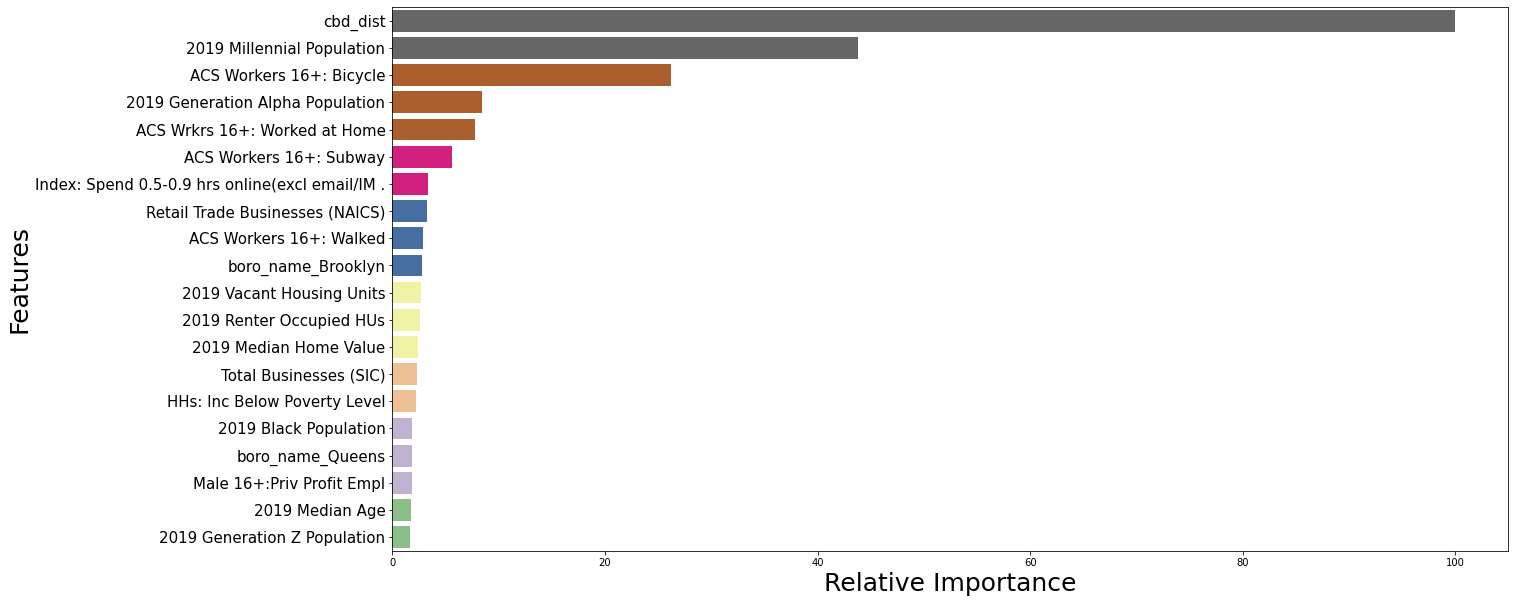

In [72]:
feature_imp_RF = model_RF.feature_importances_

#relative feature importance  
rel_feature_imp = 100 * (feature_imp_RF / max(feature_imp_RF)) 
rel_feature_imp = pd.DataFrame({'features':list(X_train.columns),
                                'rel_importance':rel_feature_imp })

rel_feature_imp = rel_feature_imp.sort_values('rel_importance', ascending=False)


#plotting the top twenty important features
top20_features = rel_feature_imp.head(20) 

plt.figure(figsize=[20,10])
plt.yticks(fontsize=15)
ax = sns.barplot(x="rel_importance", y="features",
                 data=top20_features,
                 palette="Accent_r")

plt.xlabel("Relative Importance", fontsize=25)
plt.ylabel("Features", fontsize=25)
plt.show()

In [73]:
rel_feature_imp.head()

,features,rel_importance
5,cbd_dist,100.000000
66,2019 Millennial Population,43.829283
12,ACS Workers 16+: Bicycle,26.252725
59,2019 Generation Alpha Population,8.412136
47,ACS Wrkrs 16+: Worked at Home,7.807215


In [74]:
# GradientBoosting with non scaled data
# this model uses the default parameters of GB algorithm, while the estimators are changed to obtain the best fit 
model_GB_nonscale = GradientBoostingRegressor(n_estimators=500, random_state=60)

# Train the model
model_GB_nonscale.fit(X_train, y_train_array)

# Training metrics for Gradient Boosting Regressor model
print('Training metrics for Gradient Boosting Regressor model using scaled data')

ypred_GB_train = model_GB_nonscale.predict(X_train)
print('r-square_GB_Train: ', round(model_GB_nonscale.score(X_train, y_train_array), 2))

mse_RF_train = metrics.mean_squared_error(y_train_array, ypred_GB_train)
print('RMSE_GB_Train: ', round(np.sqrt(mse_RF_train), 4))

mean_absolute_error_RF_train = metrics.mean_absolute_error(y_train_array, ypred_GB_train)
print('MAE_GB_Train: ', round(mean_absolute_error_RF_train, 4))

#Test metrics for Gradient Boosting Regressor model
print('\nTest metrics for Gradient Boosting Regressor model using scaled data')

ypred_GB_test = model_GB_nonscale.predict(X_test)
print('r-square_GB_Test: ', round(model_GB_nonscale.score(X_test, y_test_array),2))

mse_RF_Test = metrics.mean_squared_error(y_test_array, ypred_GB_test)  
print('RMSE_GB_Test: ', round(np.sqrt(mse_RF_Test),4))

mean_absolute_error_GB_Test = metrics.mean_absolute_error(y_test_array, ypred_GB_test)
print('MAE_GB_Test: ', round(mean_absolute_error_GB_Test, 4))

Training metrics for Gradient Boosting Regressor model using scaled data
r-square_GB_Train:  0.99
RMSE_GB_Train:  3.2031
MAE_GB_Train:  2.3351

Test metrics for Gradient Boosting Regressor model using scaled data
r-square_GB_Test:  0.87
RMSE_GB_Test:  17.038
MAE_GB_Test:  8.8626


In [75]:
#checking the feature importance for the Gradient Boosting regressor
feature_imp_GB = model_GB_nonscale.feature_importances_
rel_feature_imp_GB = 100 * feature_imp_GB / max(feature_imp_GB)
rel_feature_imp_GB = pd.DataFrame({'features':list(X_train.columns),
                                   'rel_importance':rel_feature_imp_GB})
rel_feature_imp_GB = rel_feature_imp_GB.sort_values('rel_importance', ascending=False)
rel_feature_imp_GB.head()

,features,rel_importance
5,cbd_dist,100.000000
66,2019 Millennial Population,44.824083
12,ACS Workers 16+: Bicycle,37.795798
43,ACS Workers 16+: Subway,26.665379
59,2019 Generation Alpha Population,12.863335


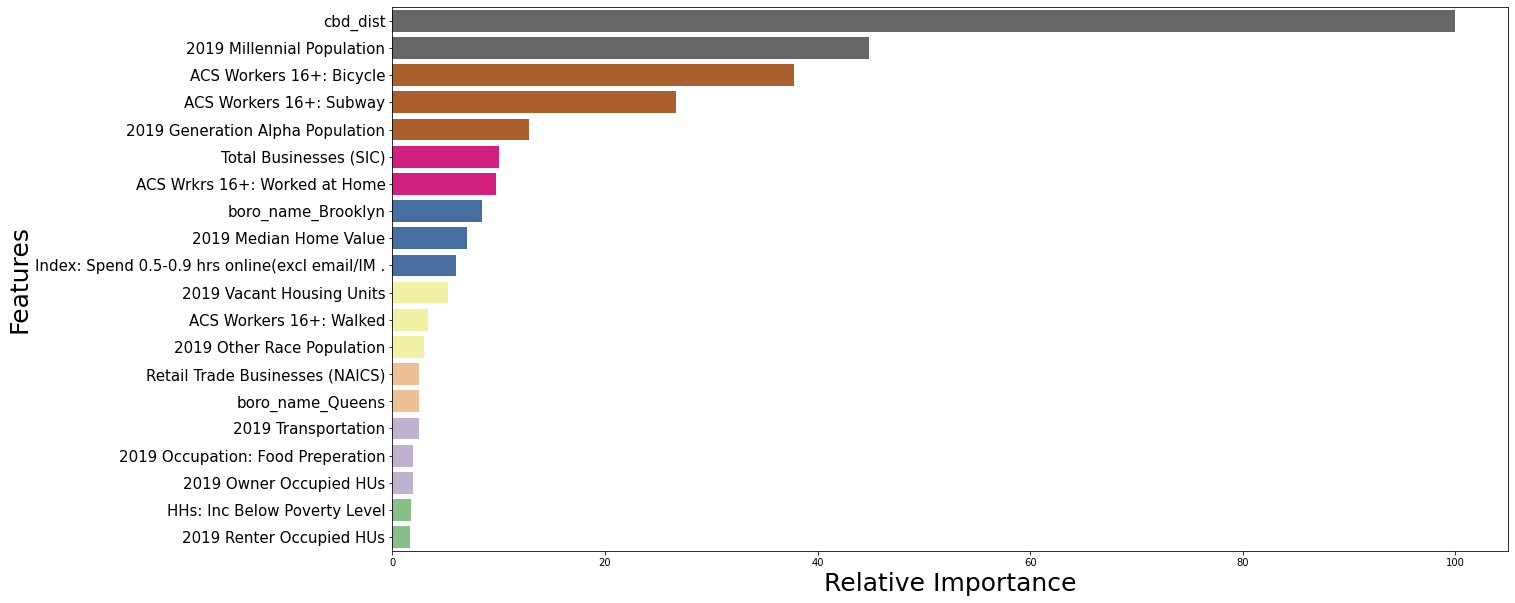

In [76]:
# Plot  feature importance for the Gradient Boosting regressor
top20_features_GB = rel_feature_imp_GB.head(20) 

plt.figure(figsize=[20,10])
plt.yticks(fontsize=15)
ax = sns.barplot(x="rel_importance", y="features", data = top20_features_GB, palette="Accent_r")
plt.xlabel("Relative Importance", fontsize=25)
plt.ylabel("Features", fontsize=25)
plt.show()

In [77]:
# Validating with a 10 fold cross validation for the Gradient Boosting models
y_array = y.values.flatten()

modelGB_cross_val = GradientBoostingRegressor(n_estimators=500, random_state=60) 

modelGB_cross_val_scores = cross_val_score(modelGB_cross_val,
                                           X, 
                                           y_array,
                                           cv=10,
                                           scoring='neg_mean_absolute_error')

print("All Model Scores: ", modelGB_cross_val_scores)

print("Negative Mean Absolute Error: {}".format(np.mean(modelGB_cross_val_scores)))

All Model Scores:  [ -8.33142457 -11.64242979 -10.21738713 -22.63124099  -6.17682192
 -37.41190813 -16.36238627 -10.9133925   -5.25388827  -6.92617155]
Negative Mean Absolute Error: -13.586705111504155


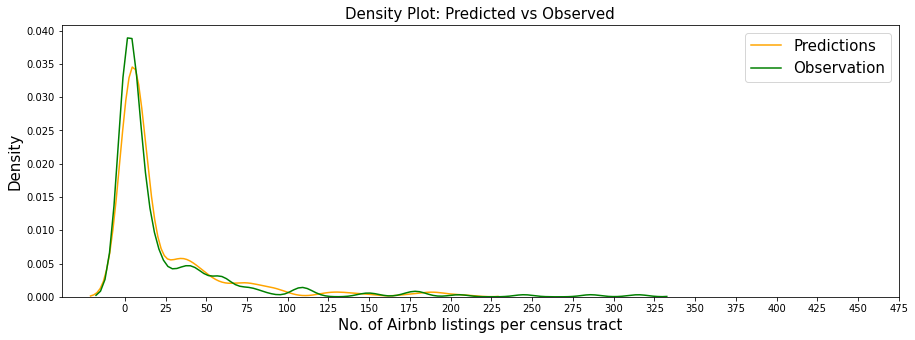

In [78]:
# Plotting a kernel density map of the predicted vs. observed data
plt.figure(figsize=[15,5])

# plotting the prediction
sns.kdeplot(ypred_RF_test, label = 'Predictions', color = 'orange')
y_observed = np.array(y_test).reshape((-1, ))
sns.kdeplot(y_observed, label = 'Observation', color = 'green')

# label the plot
plt.xlabel('No. of Airbnb listings per census tract', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title('Density Plot: Predicted vs Observed', fontsize=15)
plt.xticks(range(0,500,25), fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=15)
plt.show()

In [79]:
# Converting the predicted and observed values to dataframe and plotting the observed vs predicted
y_test_df = y_test.copy()
y_test_df['Predicted'] = (ypred_RF_test)  
y_test_df.head()

,total_airbnb,Predicted
20,4,4.614
910,6,4.288
685,2,5.972
450,1,2.036
1044,2,12.436


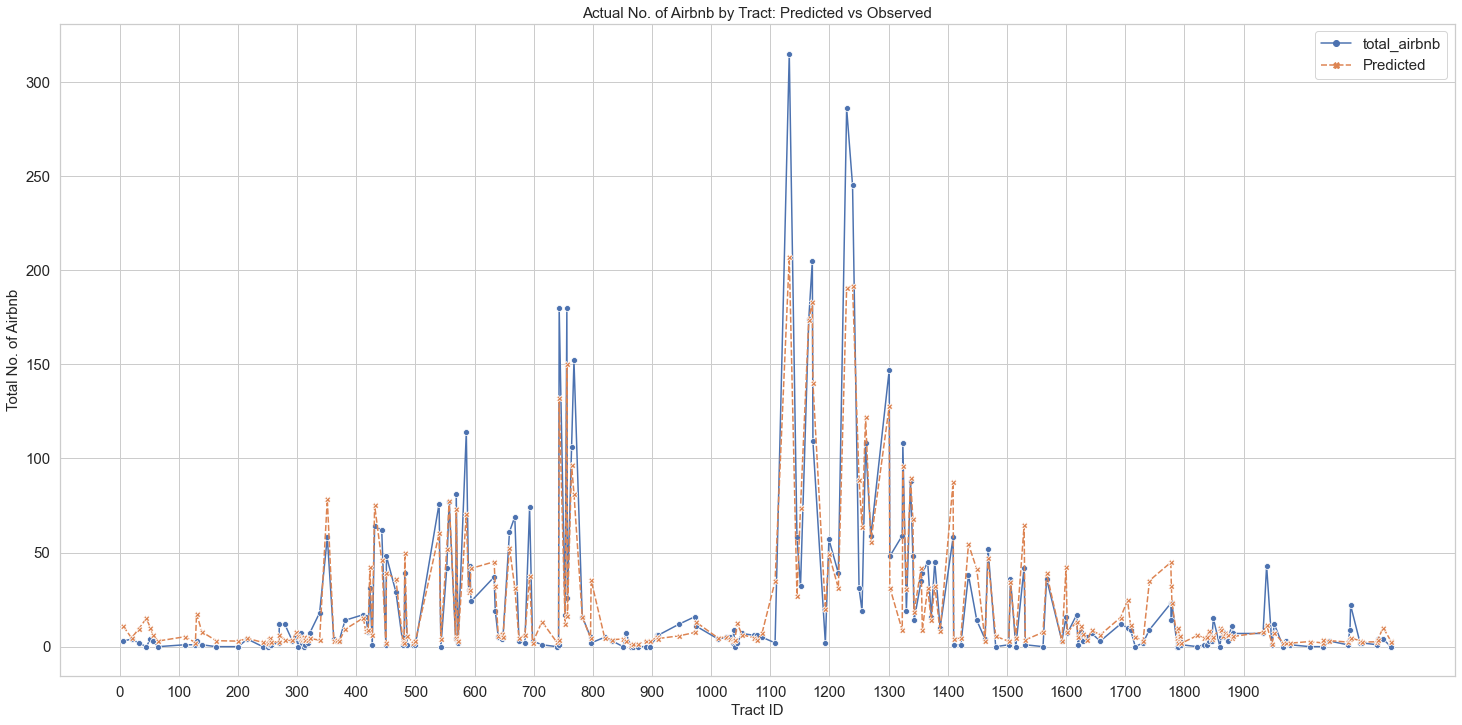

In [80]:
# plotting the actual observed vs predicted airbnb properties by tract
plt.figure(figsize = [25,12])
sns.set(style = 'whitegrid')
sns.lineplot(data = y_test_df, markers=True, hue="logic") 

#label the plot
plt.xlabel('Tract ID', fontsize=15)
plt.ylabel('Total No. of Airbnb', fontsize=15)
plt.title('Actual No. of Airbnb by Tract: Predicted vs Observed', fontsize=15)
plt.xticks(range(0,2000,100), fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='x-large', title_fontsize='10')
plt.legend(fontsize=15)
plt.show()

Shapefile	Source	Link
airbnb_nyc2019	NYC Airbnb Data Inside Airbnb:Get the Data	http://insideairbnb.com/get-the-data.html
nyc_tract_fulll	NYC Open Data: 2010 Census Tracts (water areas included)	https://data.cityofnewyork.us/City-Government/2010-Census-Tracts-water-areas-included-/gx7x-82rk
busi_distr	NYC Open Data: Business Improvement Districts	https://data.cityofnewyork.us/Business/Business-Improvement-Districts/ejxk-d93y
cbd	NYC Open Data: Business Improvement Districts	https://data.cityofnewyork.us/Business/Business-Improvement-Districts/ejxk-d93y
bus_stop	NYC Open Data: Bus Stop Shelters	https://data.cityofnewyork.us/Transportation/Bus-Stop-Shelters/qafz-7myz
hotels	NYC Open Data: Facilities Database	https://data.cityofnewyork.us/City-Government/Facilities-Database-Shapefile/2fpa-bnsx
railroad	NYC Open Data: Railroad Line	https://data.cityofnewyork.us/Transportation/Railroad-Line/i7a5-bsik
subwy_rt	NYC Open Data: Subway Lines	https://data.cityofnewyork.us/Transportation/Subway-Lines/3qz8-muuu
subwy_stn	NYC Open Data: Subway Stations	https://data.cityofnewyork.us/Transportation/Subway-Stations/arq3-7z49
